[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/programmable_self_assembly_into_non_simply_connected_shapes.ipynb)

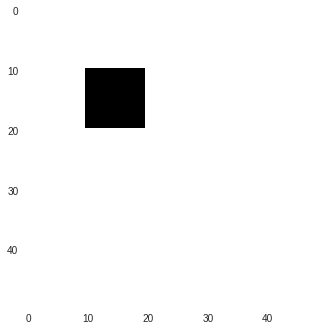

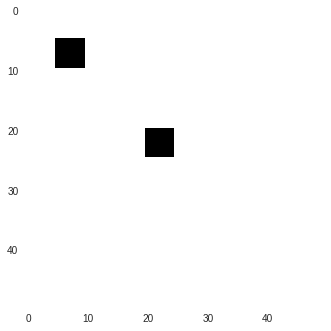

[(5, 5), (5, 6), (5, 7), (5, 8), (5, 9)]

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

# initial coordinates for agents
L = 10
scaling_factor = 5
gridshape = (scaling_factor*L,scaling_factor*L)
grid = np.zeros(gridshape)
grid[L:2*L,L:2*L] = 1
plt.imshow(grid)
plt.grid(False)
plt.show()

# make shape
shape = np.zeros(gridshape)

#shape[:L,:L] = 1

shape[L-5:L,L-5:L] = 1
shape[2*L:2*L+5,2*L:2*L+5] = 1

#shape[L:-3,L:-3] = 1
#shape[int(1.25*L):-3,int(1.25*L):-3] = 0 

plt.imshow(shape)
plt.grid(False)
plt.show()

shape_coordinates = []
for x in range(shape.shape[0]):
  for y in range(shape.shape[1]):
    if shape[x,y] == 1:
      shape_coordinates.append((x,y))
shape_coordinates[:5]

In [46]:
# instantiate agents at initial coordinates
# initialize estimated coordinates as true initial coordinates
# update_neighbors_and_distances()

agents = []

for x in range(gridshape[0]):
  for y in range(gridshape[1]):
    if grid[x,y]==1:
      agents.append({'true_coordinates':(x,y),'estimated_coordinates':(x,y),'id':len(agents),'is_source':bool((x,y)==(2*L-1,2*L-1))})

def distance_metric(a,b):
  return max(abs(a[0]-b[0]),abs(a[1]-b[1]))
  #return abs(a[0]-b[0])+abs(a[1]-b[1])

def in_radius(test_point,center,radius):
  out = False
  if distance_metric(test_point,center) <= radius:
    out = True
  return out

def get_neighbors_distances_estimations(agent,radius=1):
  center = agent['true_coordinates']
  neighbors = [i for i,a in enumerate(agents) if in_radius(a['true_coordinates'],center,radius) and a['id'] != agent['id']]
  distances = [distance_metric(agents[i]['true_coordinates'],center) for i in neighbors]
  estimated_coordinates = agent['estimated_coordinates']
  
  if len(neighbors)>0:
  
    neighbors_estimated_coordinates = [agents[n]['estimated_coordinates'] for n in neighbors]
    # DEBUG: print 'neighbors for agent id ',agent['id'],' at ',center,'are: ',neighbors
    def error_estimated_coordinates(xy):
      discrepancies = [d - distance_metric(xy,neighbors_estimated_coordinates[i]) for i,d in enumerate(distances)]
      return sum([abs(d) for d in discrepancies])

    neighbors_estimated_coordinates_x = [c[0] for c in neighbors_estimated_coordinates]
    neighbors_estimated_coordinates_y = [c[1] for c in neighbors_estimated_coordinates]
    [min_x, max_x] = [min(neighbors_estimated_coordinates_x), max(neighbors_estimated_coordinates_x)]
    [min_y, max_y] = [min(neighbors_estimated_coordinates_y), max(neighbors_estimated_coordinates_y)]
    candidate_estimations = list(itertools.product(range(min_x,max_x+1),range(min_y,max_y+1)))
    candidate_estimation_errors = [error_estimated_coordinates(xy) for xy in candidate_estimations]

    optimal_estimations = [candidate_estimations[i] for i,err in enumerate(candidate_estimation_errors) if err==min(candidate_estimation_errors)]
    estimated_coordinates = random.choice(optimal_estimations)
  
  return [neighbors,distances,estimated_coordinates]


for a in agents:
  [a['neighbors'],a['distances'],a['estimated_coordinates']] = get_neighbors_distances_estimations(a)
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (10, 10),
 'id': 0,
 'is_source': False,
 'neighbors': [1, 10, 11],
 'true_coordinates': (10, 10)}

In [47]:
# initialize gradient values.

for a in agents:
  if a['is_source']:
    a['gradient_value'] = 0
    for neighbor_index in a['neighbors']:
      neighbor = agents[neighbor_index]
      neighbor['gradient_value'] = 1
      
def do_all_agents_have_gradient_values():
  ans = True
  for a in agents:
    if 'gradient_value' not in a.keys():
      ans = False
  return ans

while not do_all_agents_have_gradient_values():
  for a in agents:
    if 'gradient_value' not in a.keys():
      neighbors = [agents[i] for i in a['neighbors']]
      min_gradient_in_neighbors = 9*10**10
      should_assign_gradient_value = False
      for neighbor in neighbors:
        if 'gradient_value' in neighbor.keys():
          min_gradient_in_neighbors = min(neighbor['gradient_value'],min_gradient_in_neighbors)
          should_assign_gradient_value = True
      if should_assign_gradient_value:
        a['gradient_value'] = 1+min_gradient_in_neighbors
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (10, 10),
 'gradient_value': 9,
 'id': 0,
 'is_source': False,
 'neighbors': [1, 10, 11],
 'true_coordinates': (10, 10)}

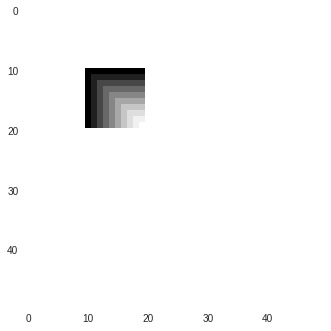

In [48]:
# check gradient
gradient = np.zeros(gridshape)
for a in agents:
  [x,y] = a['true_coordinates']
  gradient[x,y] = a['gradient_value']
  
plt.imshow(gradient)
plt.grid(False)
plt.show()

In [49]:
# edge-following

def unit_neighbors(agent):
  return [n for i,n in enumerate(agent['neighbors']) if agent['distances'][i]==1]

# 0 1 2
# 7 x 3
# 6 5 4

unit_circle = [(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1),(-1,0)]

unit_semicircles = [
    [unit_circle[n%8] for n in range(0,4)],
    [unit_circle[n%8] for n in range(1,5)],
    [unit_circle[n%8] for n in range(2,6)],
    [unit_circle[n%8] for n in range(3,7)],
    [unit_circle[n%8] for n in range(4,8)],
    [unit_circle[n%8] for n in range(5,9)],
    [unit_circle[n%8] for n in range(6,10)],
    [unit_circle[n%8] for n in range(7,11)]
]



edge_templates_numbers = [] # only need to consider cases which are actually an edge (i.e. semicircle is open)
for n in range(8):
  edge_templates_numbers.append(([n],[(n+1)%8, (n-1)%8]))
  
  edge_templates_numbers.append(([n,(n+1)%8],[(n-1)%8, (n+2)%8]))
  edge_templates_numbers.append(([n,(n+2)%8],[(n+1)%8]))
  edge_templates_numbers.append(([n,(n+3)%8],[(n+1)%8]))
  
  edge_templates_numbers.append(([n,(n+1)%8,(n+2)%8],[(n-1)%8, (n+3)%8]))
  edge_templates_numbers.append(([n,(n+1)%8,(n+3)%8],[(n+2)%8]))
  edge_templates_numbers.append(([n,(n+2)%8,(n+3)%8],[(n+1)%8]))
  
  edge_templates_numbers.append(([n,(n+1)%8,(n+2)%8,(n+3)%8],[(n-1)%8, (n+4)%8]))

edge_templates = []
for (template,moves) in edge_templates_numbers:
  template_tuples = [unit_circle[n] for n in template]
  moves_tuples = [unit_circle[n] for n in moves]
  edge_templates.append((set(template_tuples),moves_tuples))
  
def get_edge_template_moves(occupied_displacements):
  d = set(occupied_displacements)
  ans = [(0,0)]
  for (template,moves) in edge_templates:
    if d == template:
      ans = moves
      break
  return ans

def valid_moves(agent):
  # if there is a nonoccupied semicircle, then agent can move to one of the follows according to its edge template
  
  (x,y) = agent['true_coordinates']
  neighbor_coordinates = [agents[n]['true_coordinates'] for n in unit_neighbors(agent)]
  occupied_displacements = [(dx,dy) for (dx,dy) in unit_circle if (x+dx,y+dy) in neighbor_coordinates]
  nonoccupied_displacements = [d for d in unit_circle if d not in occupied_displacements]
  agent_is_on_edge = any([set(s)<=set(nonoccupied_displacements) for s in unit_semicircles])
  
  if not agent_is_on_edge:
    valid_moves = [(0,0)]
  else:
    edge_template_moves = get_edge_template_moves(occupied_displacements)
    nonoccupied_displacements_in_grid = [(dx,dy) for (dx,dy) in nonoccupied_displacements if x+dx in range(gridshape[0]) and y+dy in range(gridshape[1])]
    valid_moves = list(set(edge_template_moves).intersection(nonoccupied_displacements_in_grid))
    if valid_moves==[]:
      valid_moves = [(0,0)]
  return valid_moves

def estimated_distance_to_shape(agent,prospective_move):
  (x,y) = agent['estimated_coordinates']
  (dx,dy) = prospective_move
  prospective_estimated_coordinates = (x+dx,y+dy)
  distances = [distance_metric(prospective_estimated_coordinates,p) for p in shape_coordinates]
  return min(distances)

def chosen_move(agent,shape_coordinates):
  prospective_moves = valid_moves(agent)
  prospective_distances = [estimated_distance_to_shape(agent,m) for m in prospective_moves]
  min_distance = min(prospective_distances)
  optimal_moves = [prospective_moves[i] for i,d in enumerate(prospective_distances) if d==min_distance]
  # DEBUG - print 'chosen_displacement - displacements:',displacements
  # DEBUG - print 'chosen_displacement - distances:',distances
  # DEBUG - print 'chosen_displacement - optimal_displacements:',optimal_displacements
  return random.choice(optimal_moves)

print valid_moves(agents[-2])
print [estimated_distance_to_shape(agents[-2],d) for d in valid_moves(agents[-2])]
print chosen_move(agents[-2],shape_coordinates) 

[(0, 0)]
[2]
(0, 0)


In [0]:
def timestep(agents=agents,shape_coordinates=shape_coordinates):
  movable_agents = [i for i,a in enumerate(agents) if len(valid_moves(a))>1]
  #print movable_agents
  selected_agent = agents[random.choice(movable_agents)]
  
  #print selected_agent
  #print 'valid moves:',valid_moves(selected_agent)
  #print 'distance to shape for each move:',[estimated_distance_to_shape(selected_agent,d) for d in valid_moves(selected_agent)]
  (x,y) = selected_agent['true_coordinates']
  (dx,dy) = chosen_move(selected_agent,shape_coordinates)
  #print 'chosen move:',(dx,dy)
    
  selected_agent['true_coordinates'] = (x+dx,y+dy)
  previous_neighbors = selected_agent['neighbors']
  
  def update_agent(a):
    [a['neighbors'],a['distances'],a['estimated_coordinates']] = get_neighbors_distances_estimations(a)
  update_agent(selected_agent)
  new_neighbors = selected_agent['neighbors']
  
  agents_to_update = list(set(previous_neighbors).union(set(new_neighbors)))
  for i in agents_to_update:
    update_agent(agents[i])  

def plot_grid():
  grid = np.zeros((scaling_factor*L,scaling_factor*L))
  for s in shape_coordinates:
    grid[s]=0.5
  for a in agents:
    grid[a['true_coordinates']]=1
  plt.imshow(grid)
  plt.grid(False)
  plt.show()

t=0


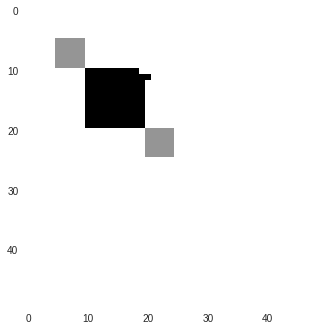

t=1


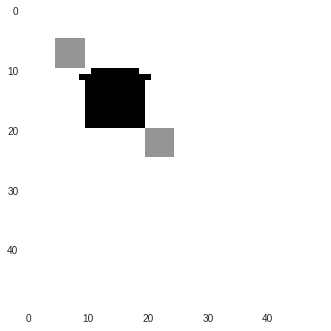

t=2


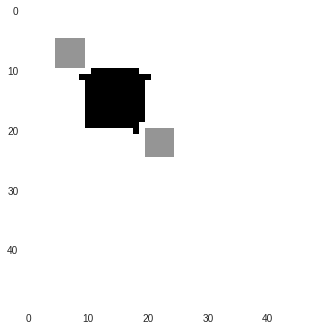

t=3


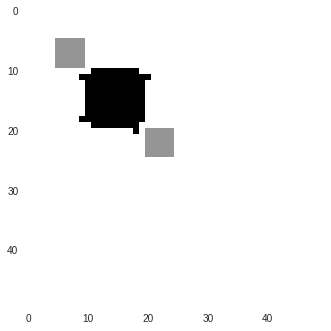

t=4


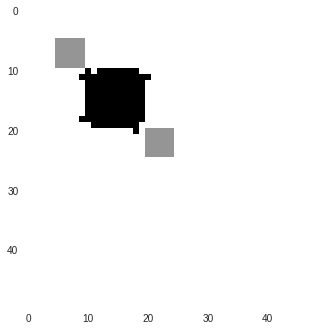

t=5


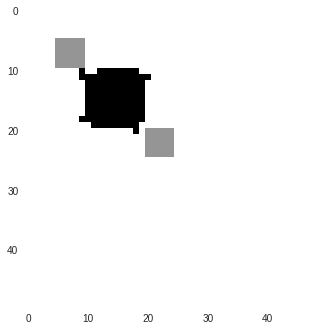

t=6


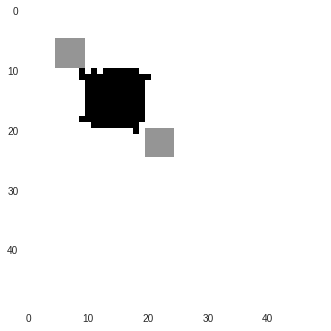

t=7


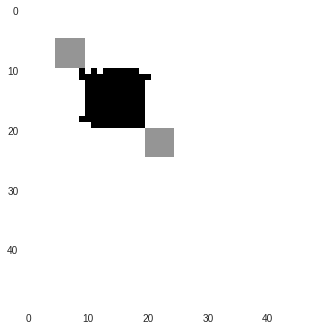

t=8


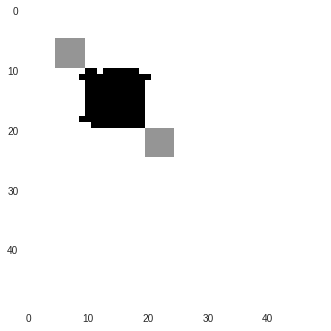

t=9


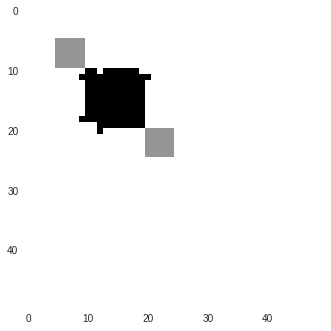

t=10


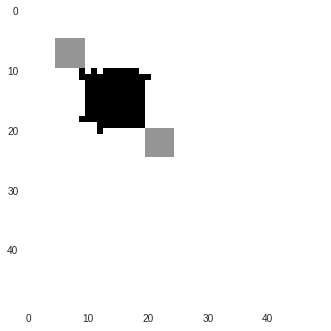

t=11


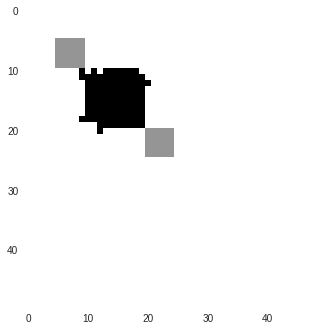

t=12


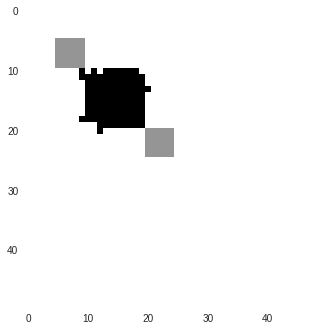

t=13


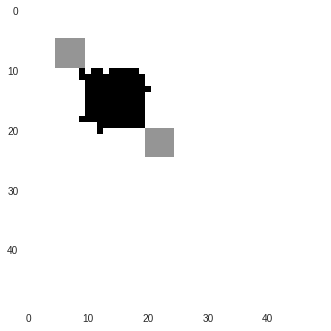

t=14


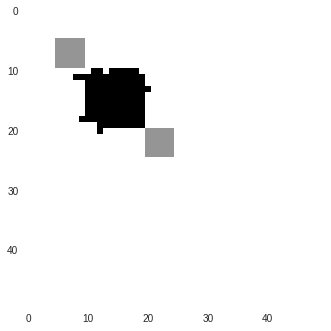

t=15


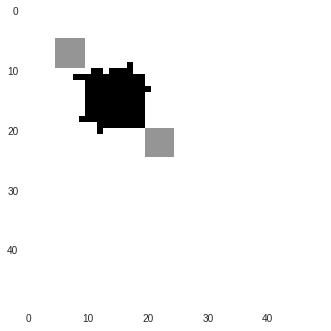

t=16


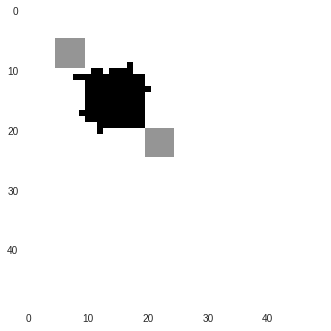

t=17


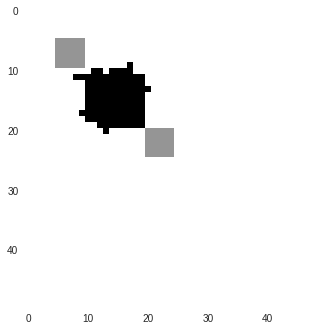

t=18


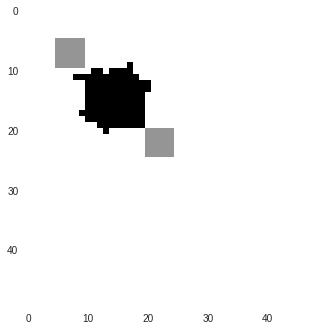

t=19


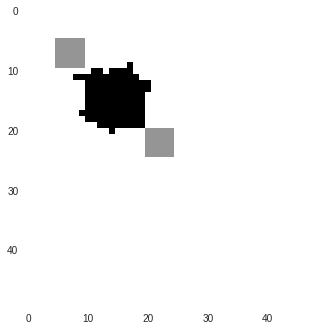

t=20


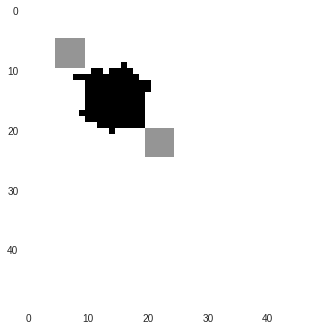

t=21


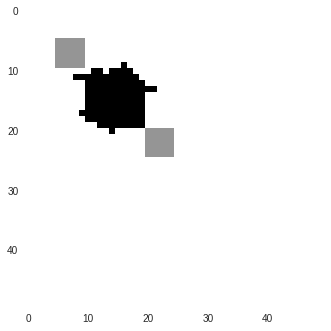

t=22


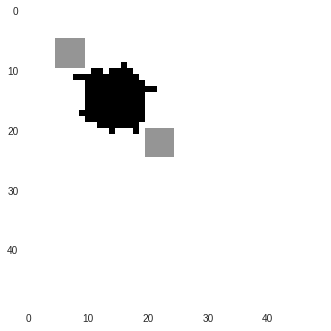

t=23


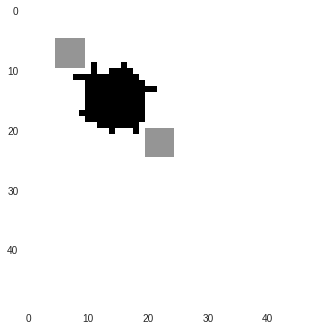

t=24


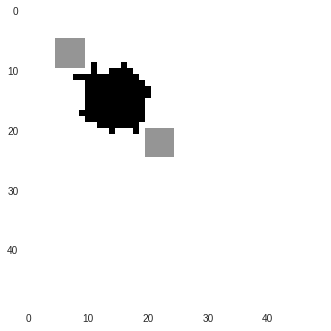

t=25


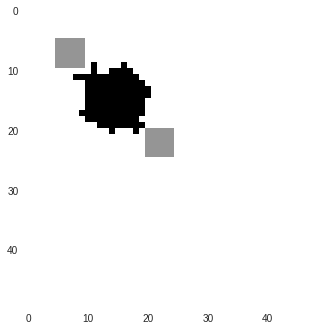

t=26


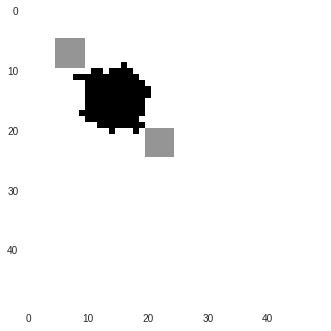

t=27


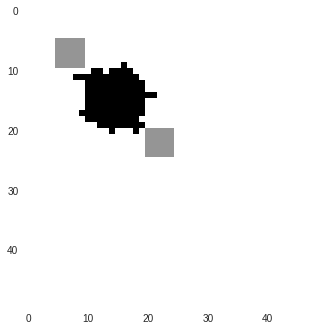

t=28


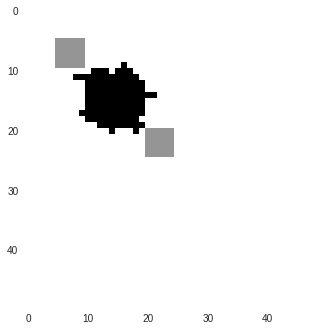

t=29


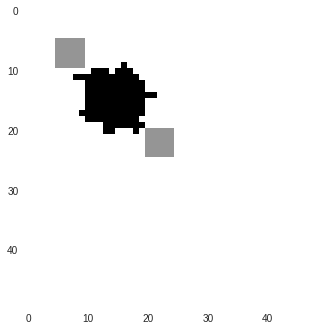

t=30


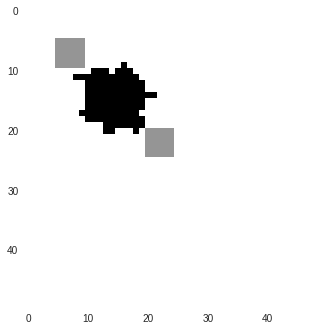

t=31


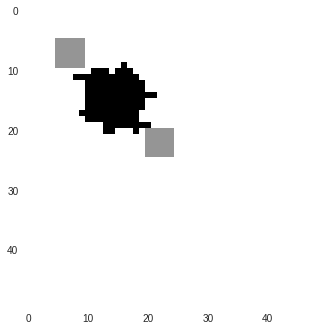

t=32


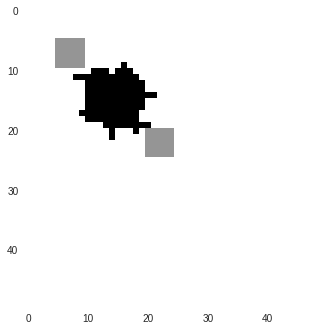

t=33


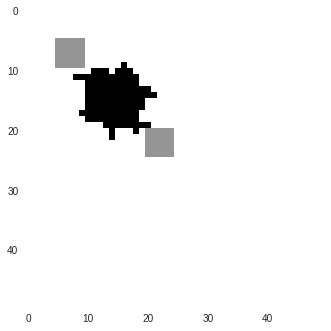

t=34


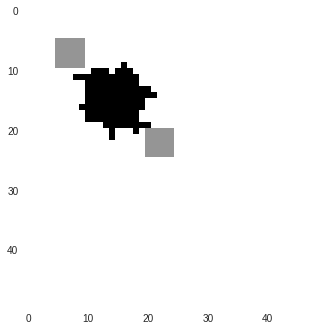

t=35


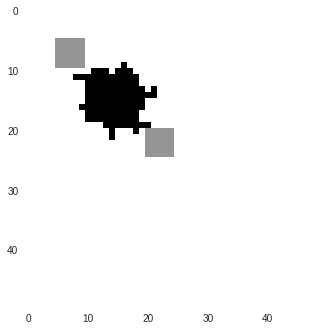

t=36


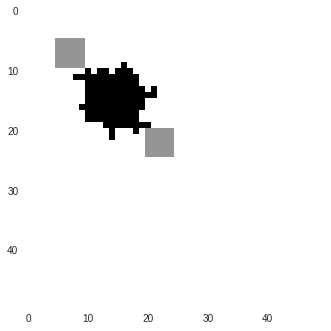

t=37


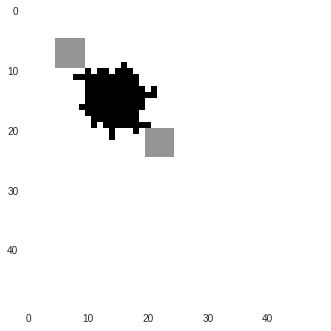

t=38


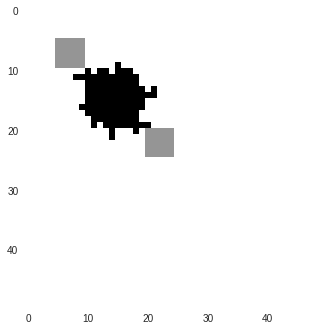

t=39


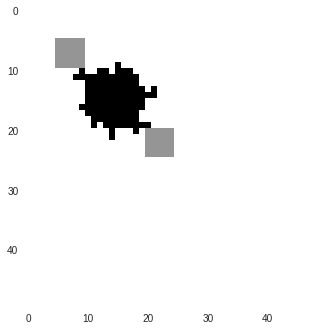

t=40


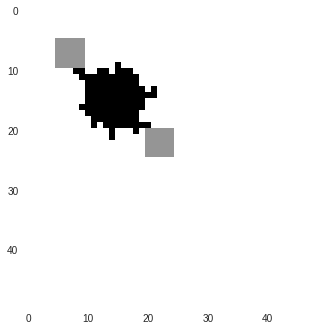

t=41


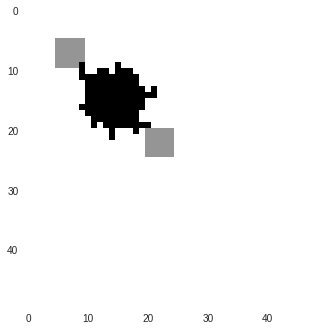

t=42


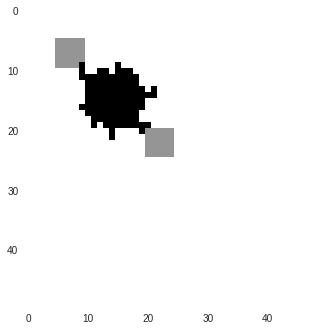

t=43


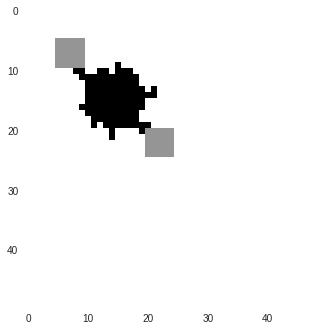

t=44


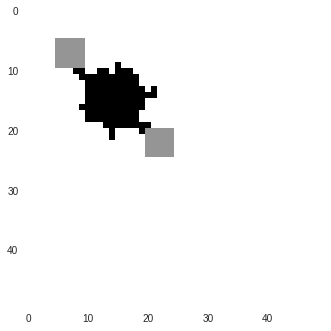

t=45


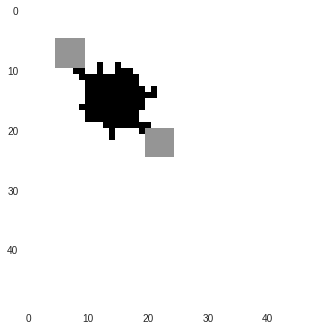

t=46


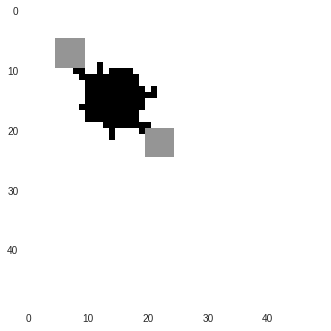

t=47


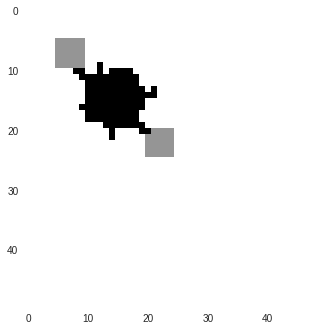

t=48


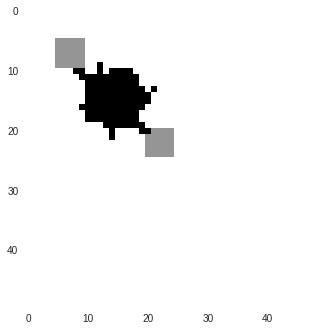

t=49


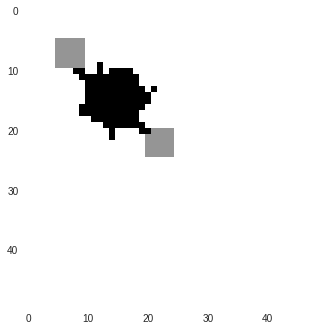

t=50


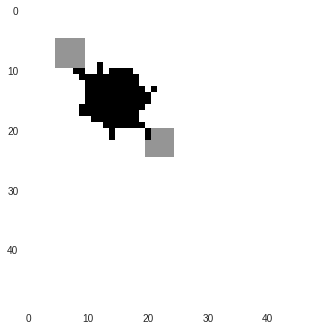

t=51


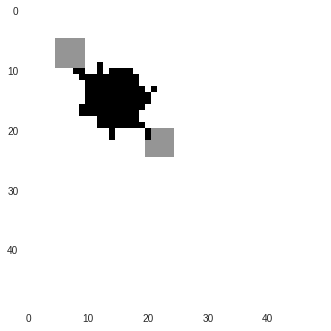

t=52


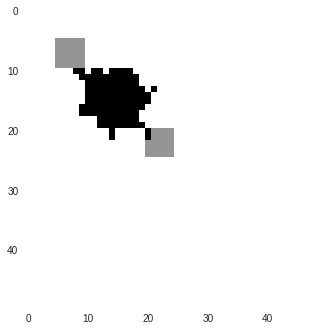

t=53


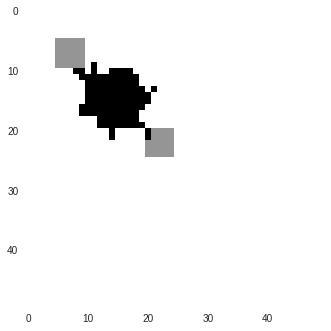

t=54


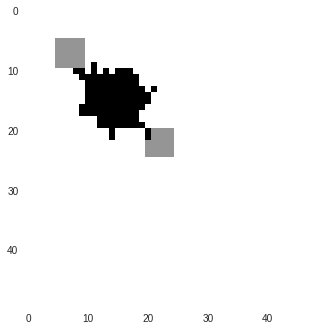

t=55


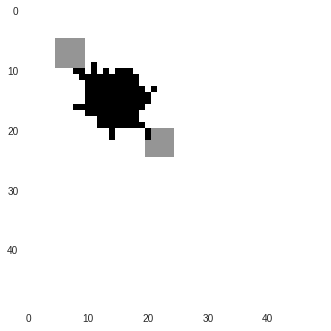

t=56


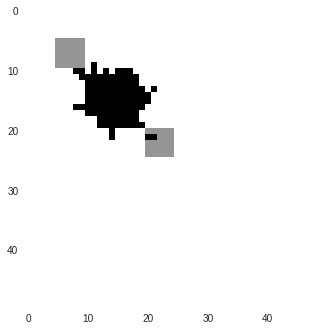

t=57


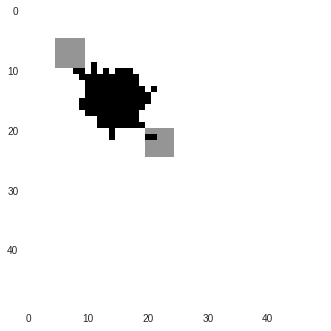

t=58


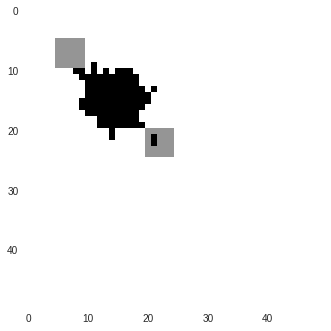

t=59


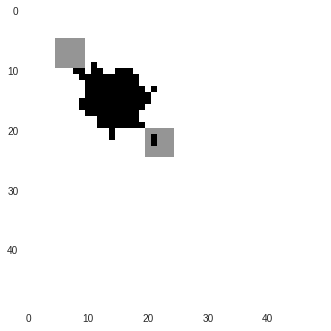

t=60


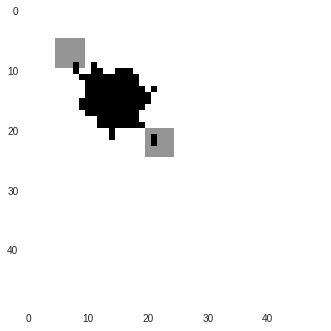

t=61


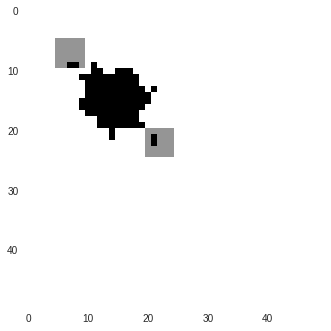

t=62


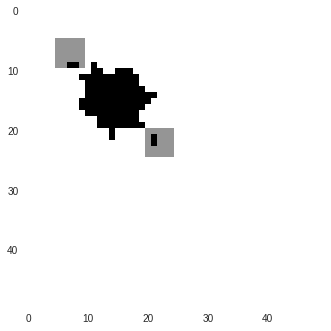

t=63


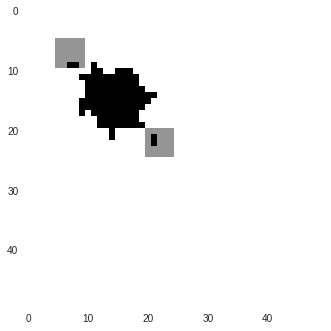

t=64


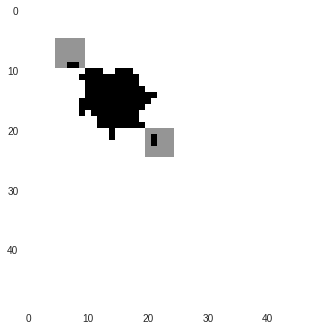

t=65


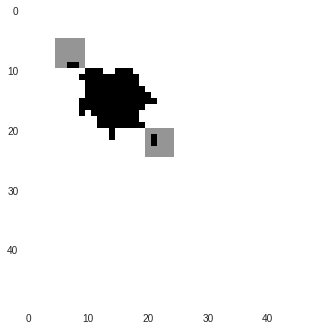

t=66


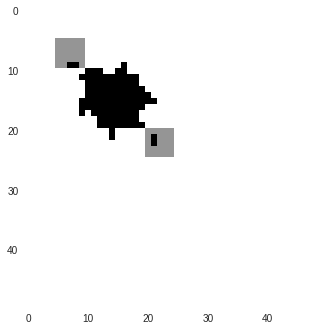

t=67


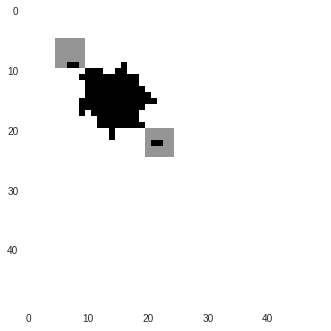

t=68


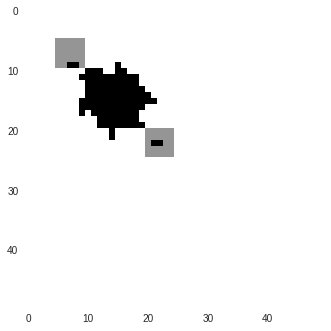

t=69


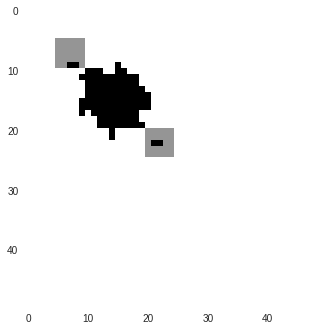

t=70


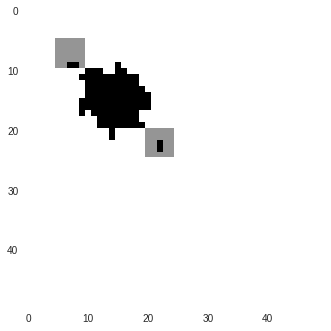

t=71


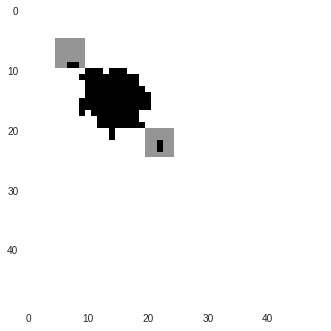

t=72


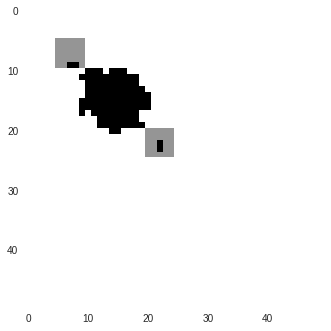

t=73


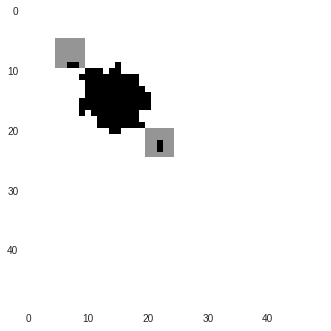

t=74


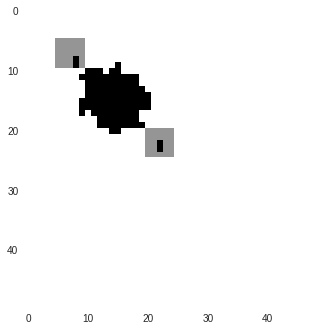

t=75


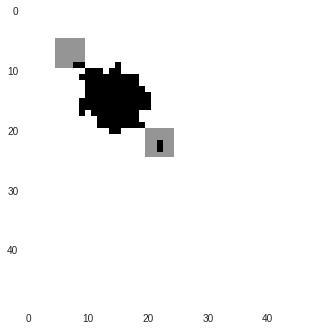

t=76


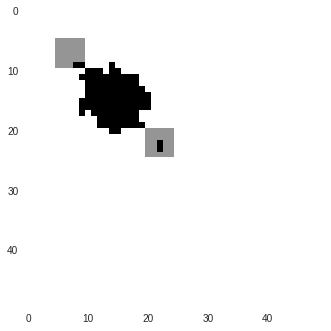

t=77


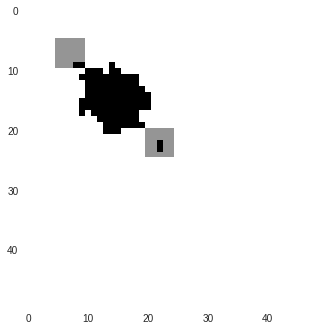

t=78


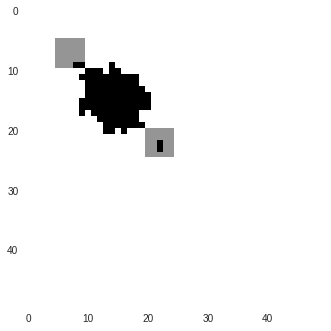

t=79


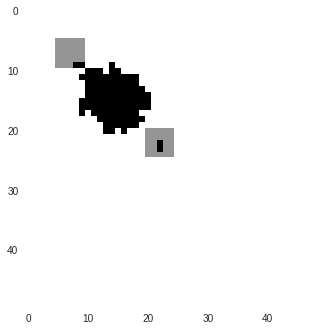

t=80


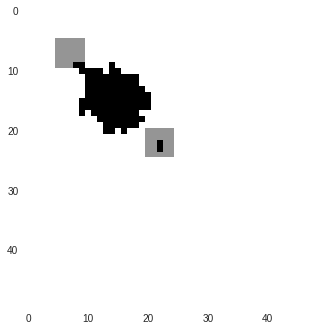

t=81


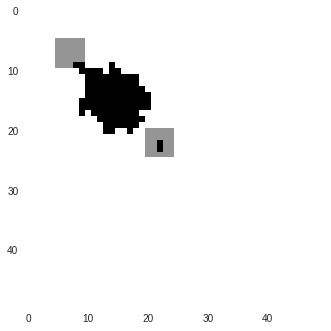

t=82


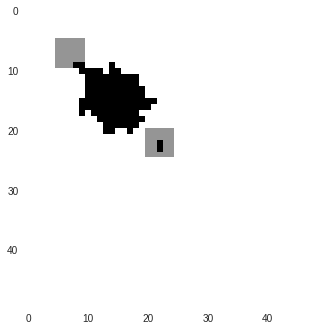

t=83


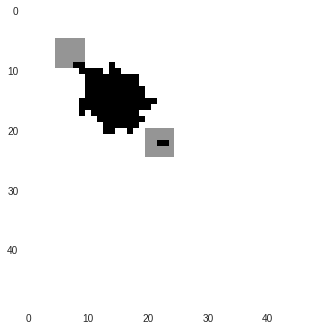

t=84


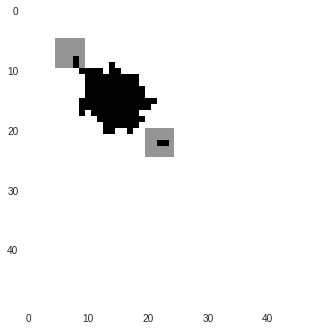

t=85


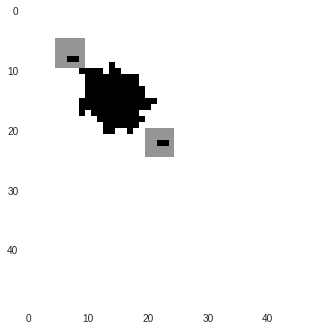

t=86


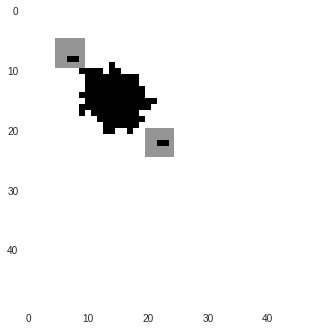

t=87


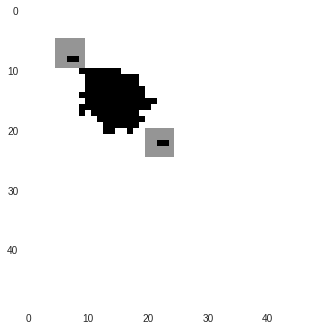

t=88


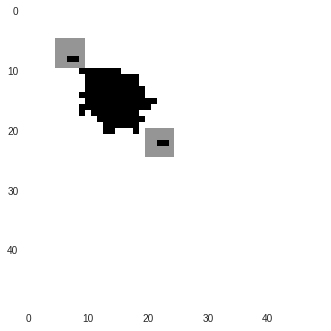

t=89


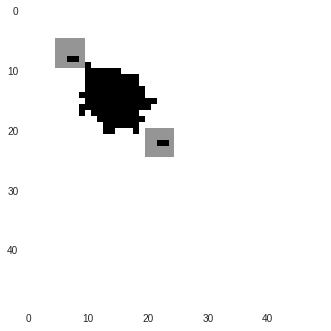

t=90


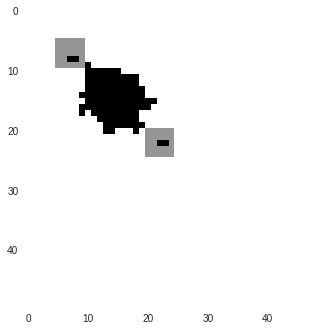

t=91


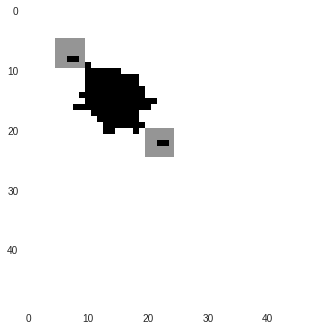

t=92


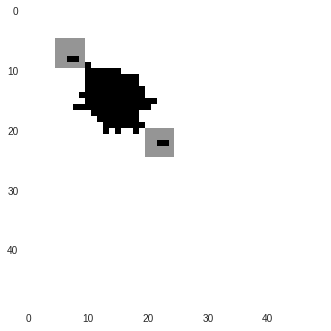

t=93


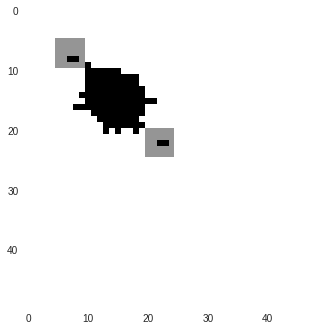

t=94


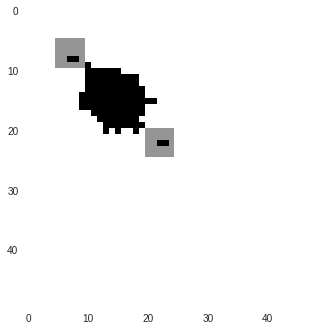

t=95


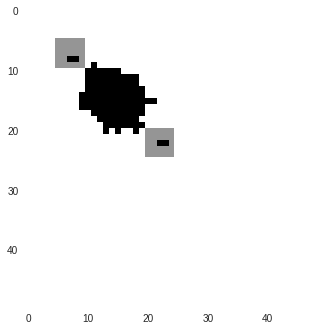

t=96


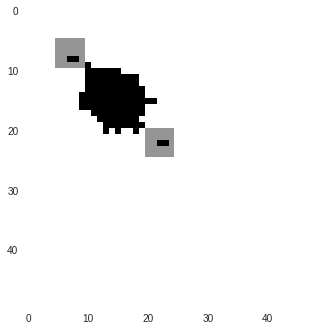

t=97


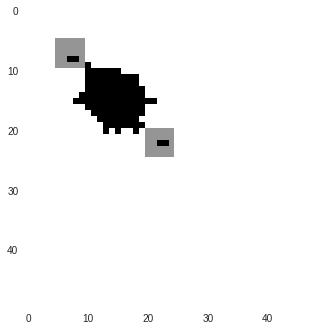

t=98


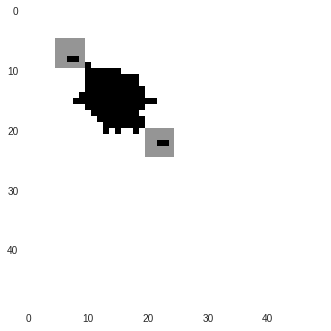

t=99


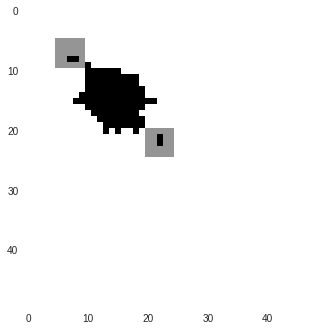

t=100


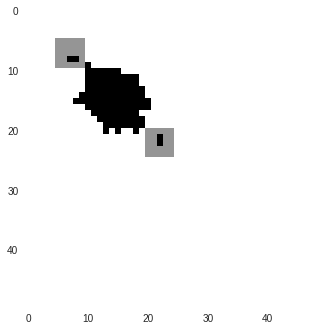

t=101


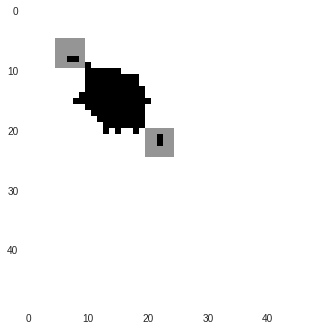

t=102


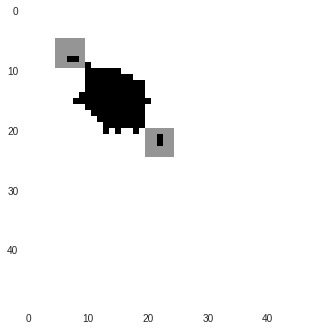

t=103


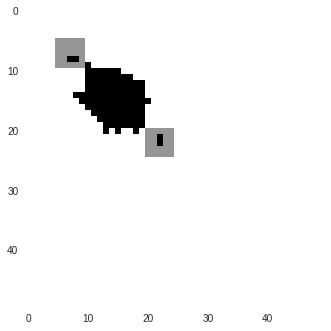

t=104


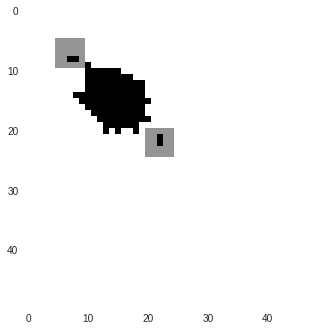

t=105


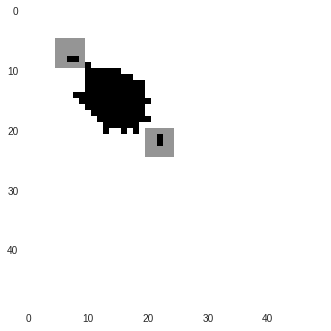

t=106


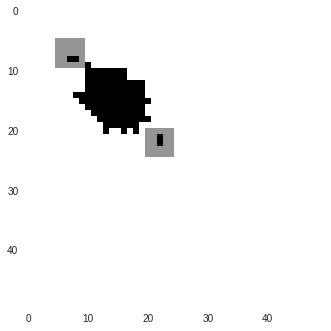

t=107


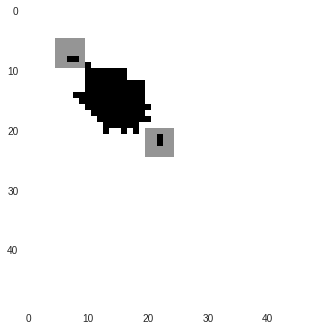

t=108


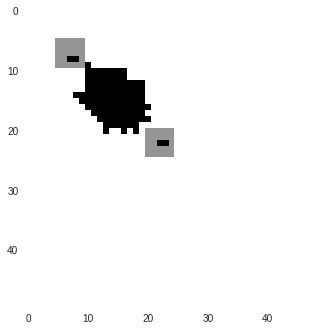

t=109


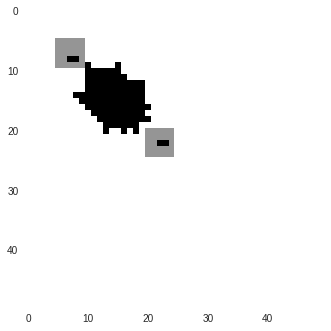

t=110


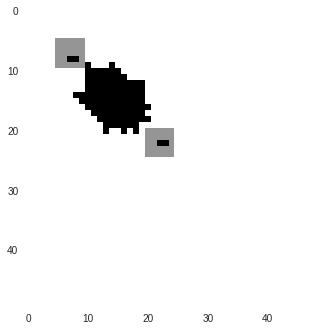

t=111


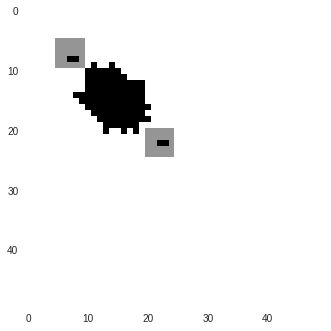

t=112


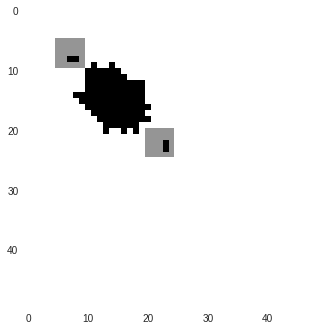

t=113


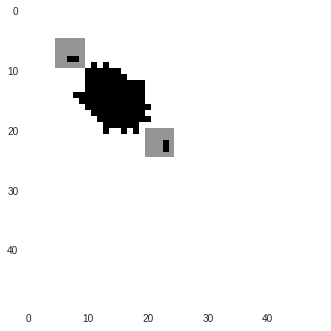

t=114


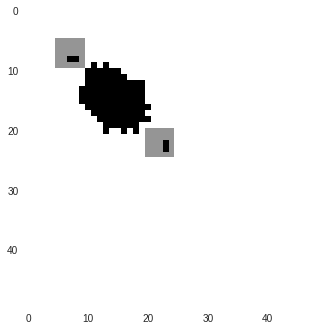

t=115


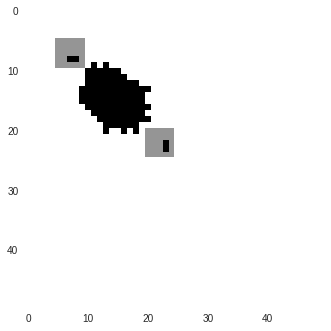

t=116


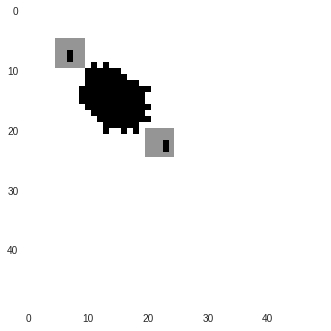

t=117


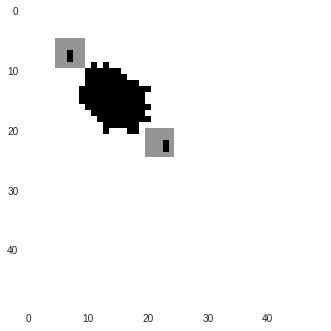

t=118


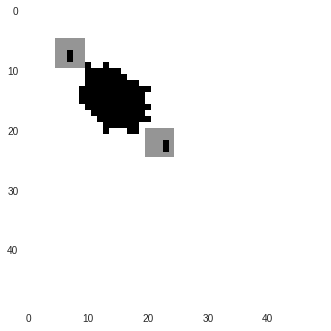

t=119


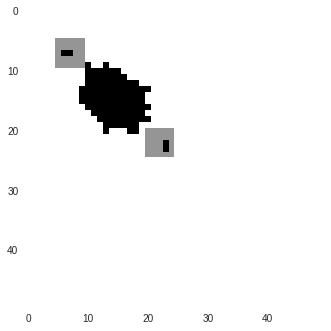

t=120


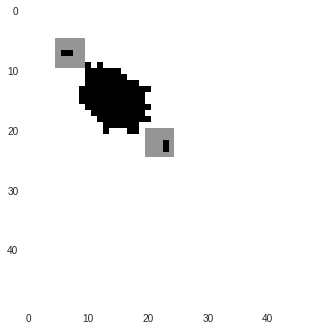

t=121


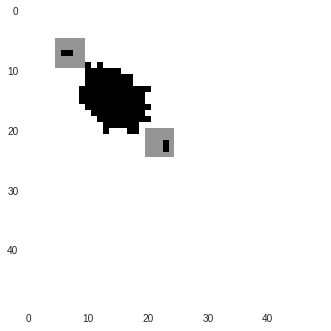

t=122


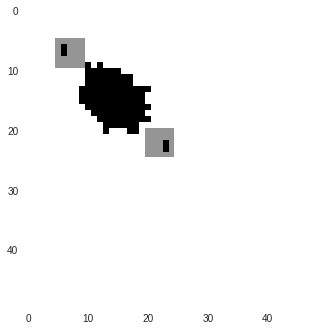

t=123


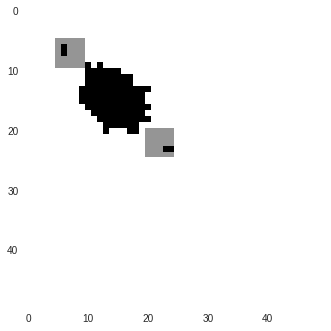

t=124


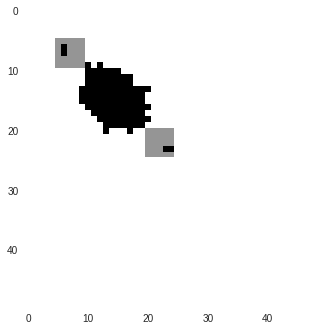

t=125


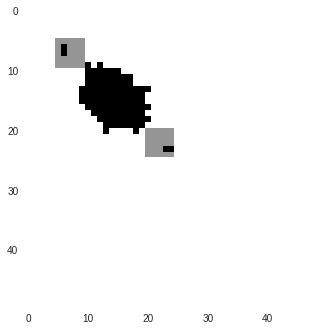

t=126


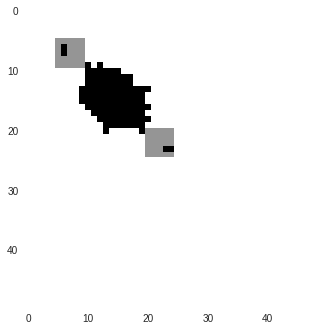

t=127


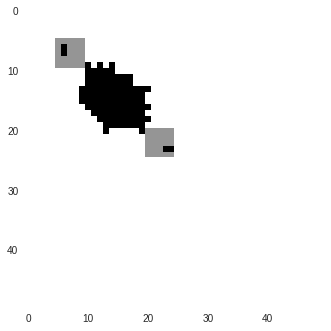

t=128


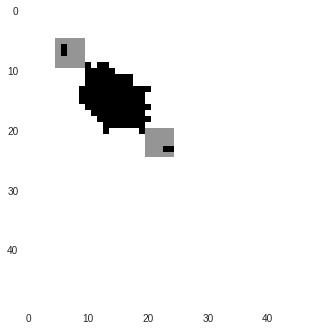

t=129


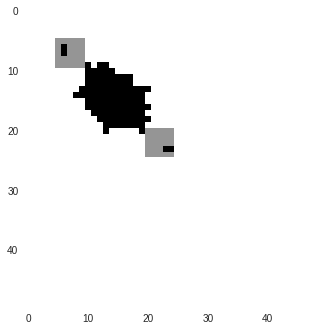

t=130


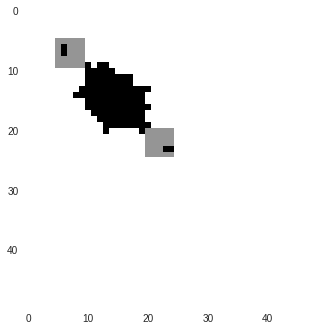

t=131


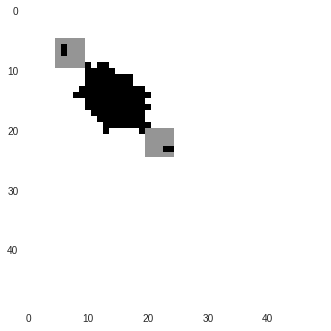

t=132


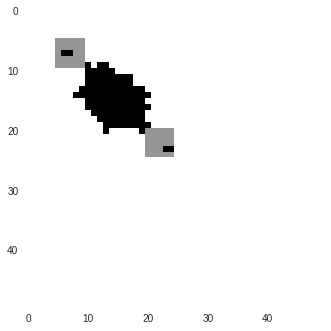

t=133


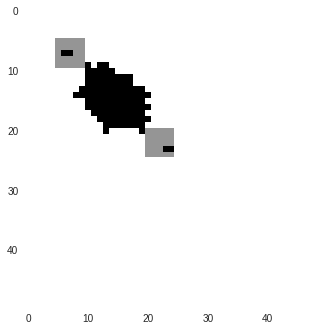

t=134


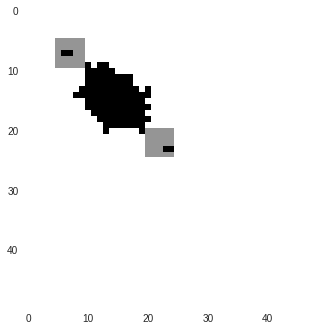

t=135


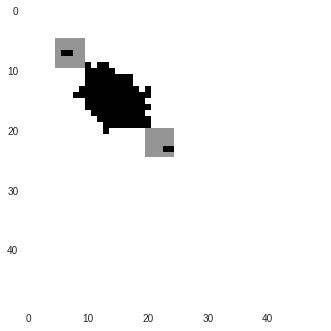

t=136


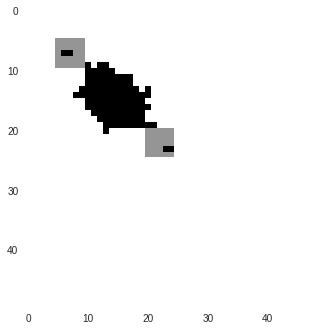

t=137


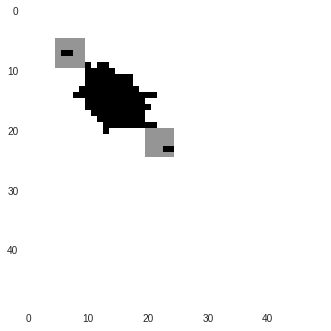

t=138


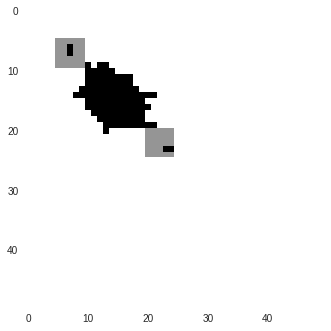

t=139


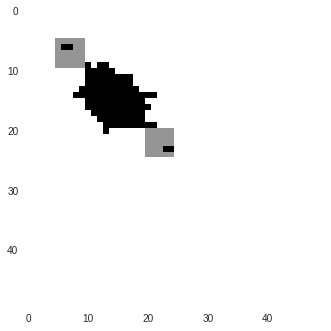

t=140


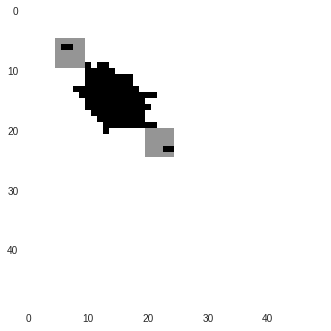

t=141


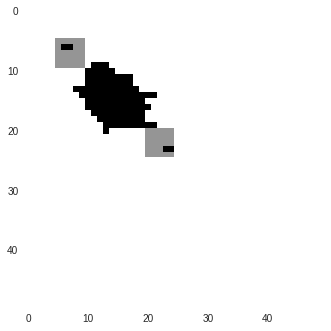

t=142


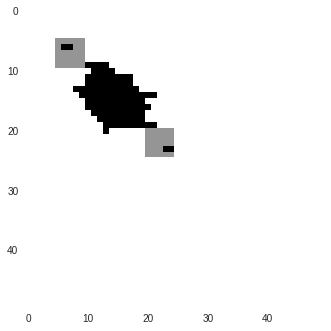

t=143


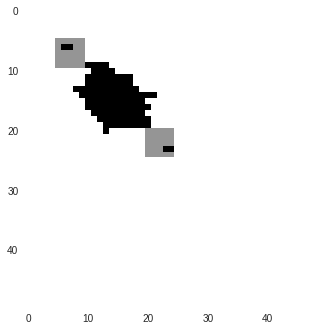

t=144


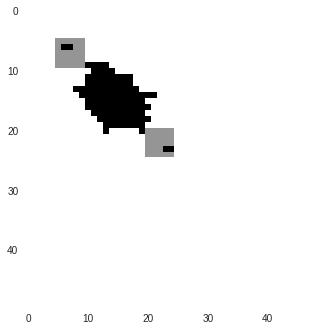

t=145


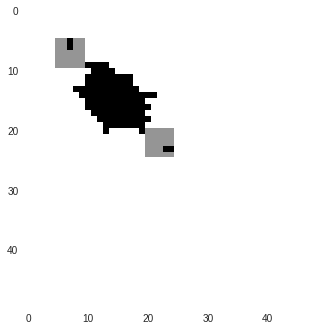

t=146


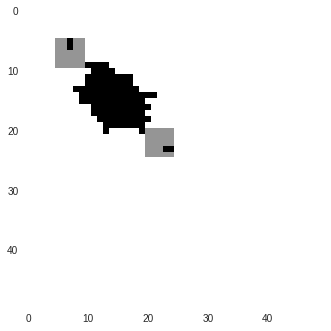

t=147


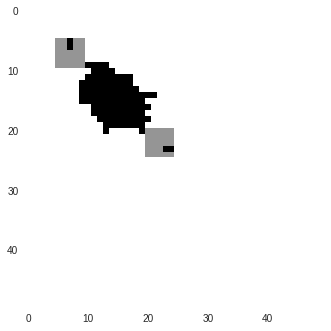

t=148


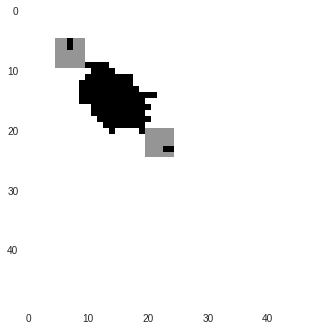

t=149


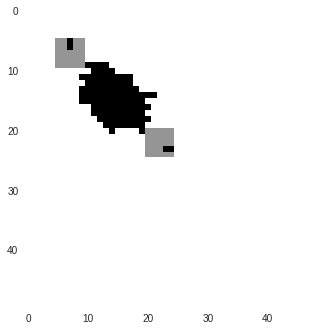

t=150


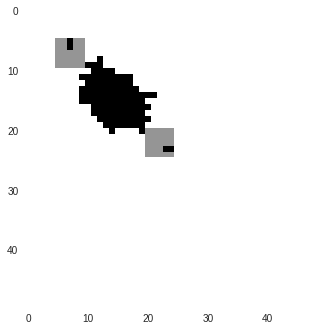

t=151


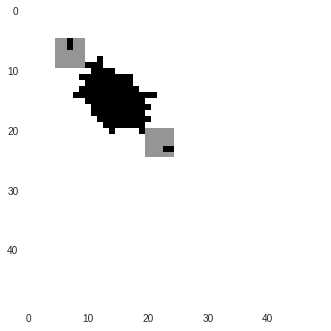

t=152


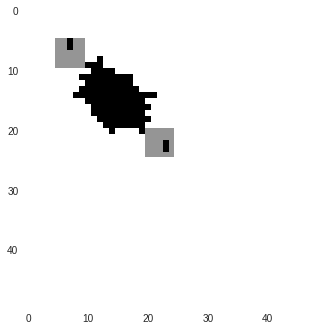

t=153


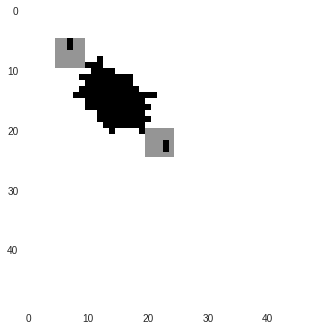

t=154


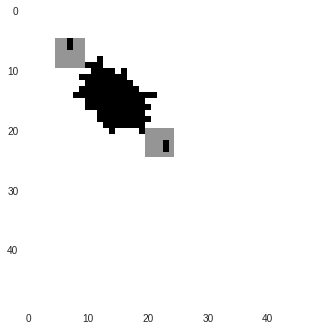

t=155


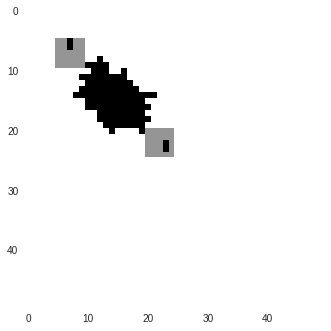

t=156


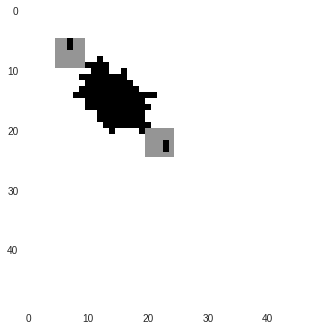

t=157


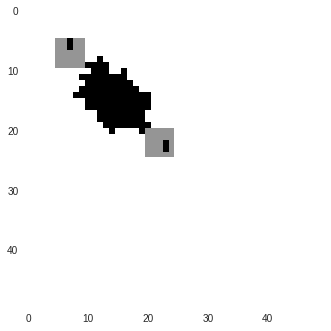

t=158


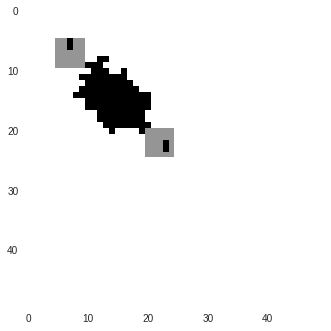

t=159


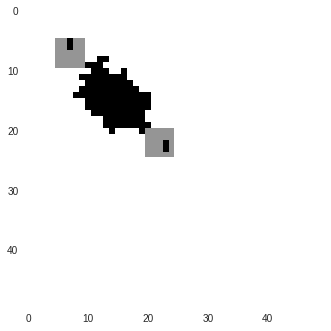

t=160


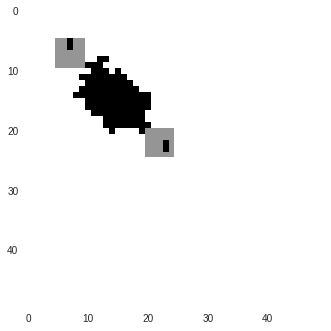

t=161


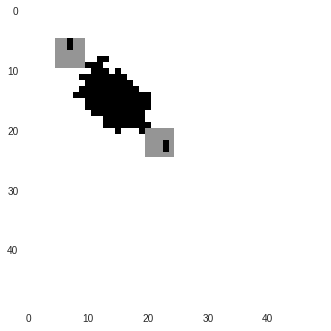

t=162


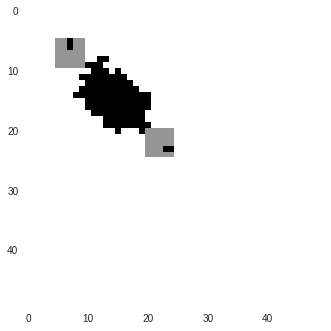

t=163


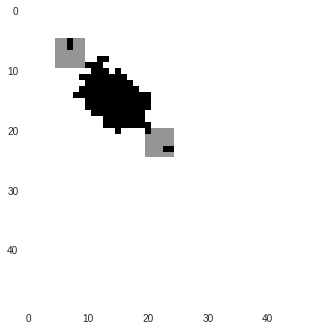

t=164


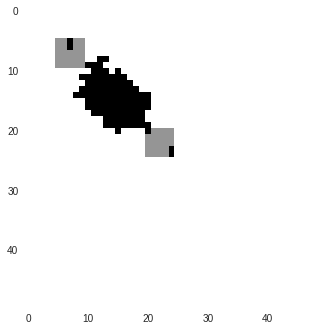

t=165


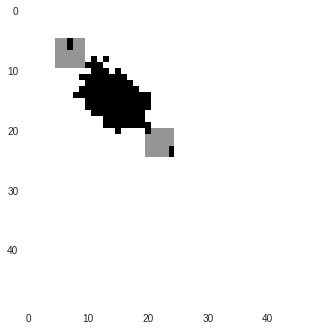

t=166


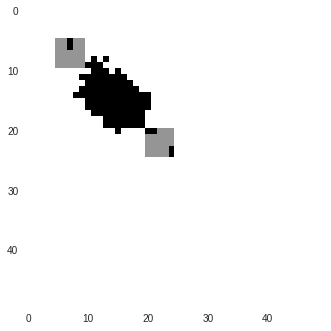

t=167


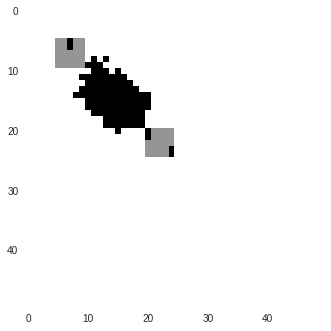

t=168


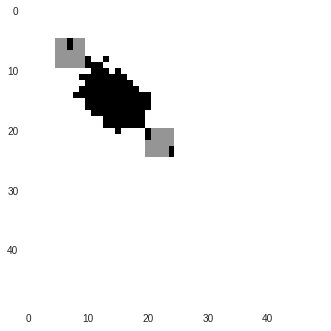

t=169


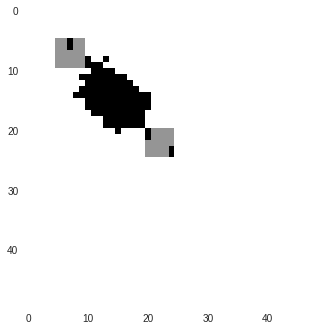

t=170


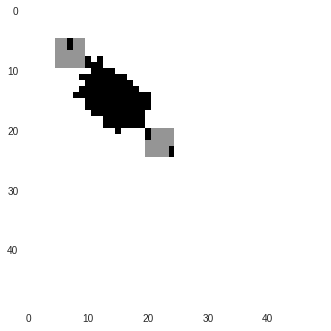

t=171


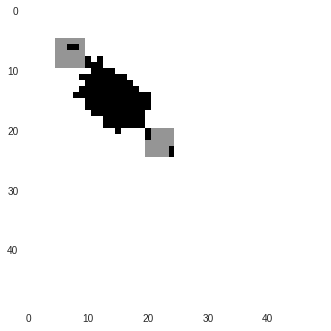

t=172


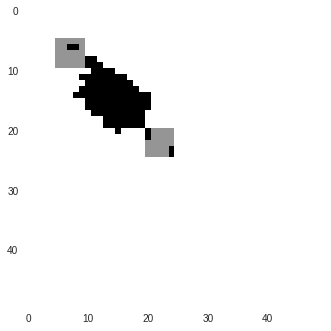

t=173


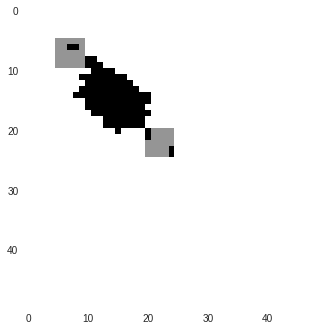

t=174


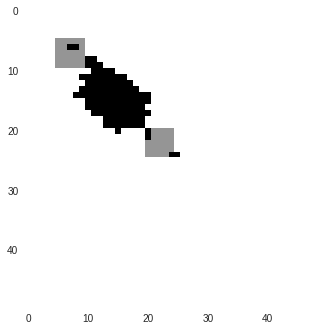

t=175


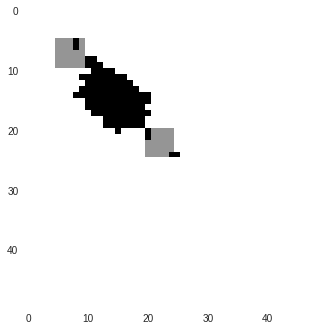

t=176


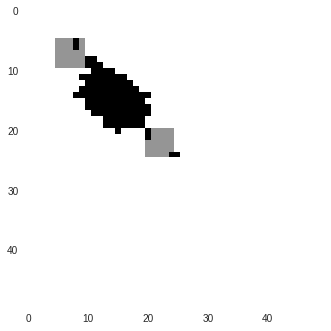

t=177


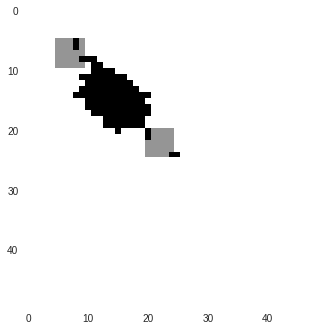

t=178


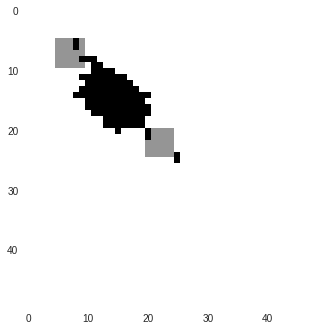

t=179


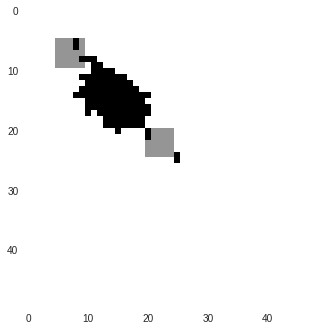

t=180


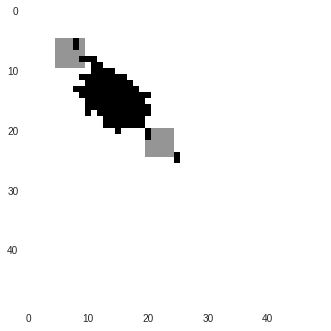

t=181


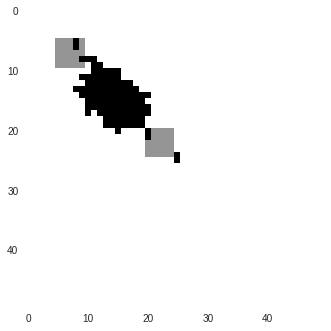

t=182


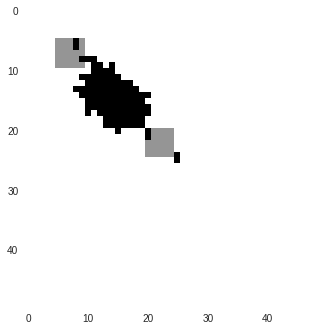

t=183


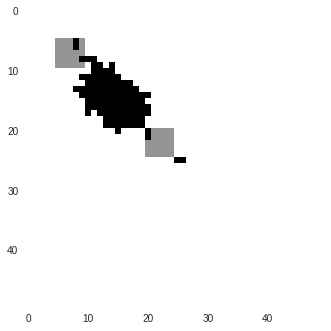

t=184


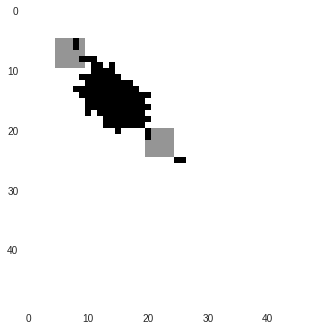

t=185


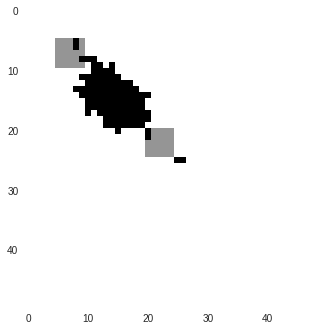

t=186


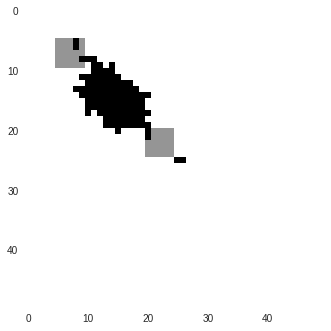

t=187


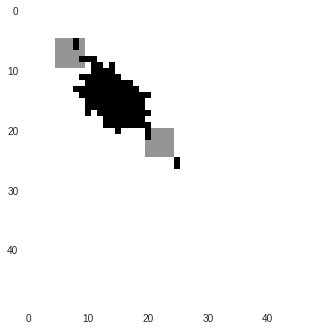

t=188


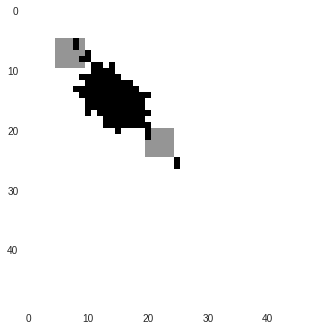

t=189


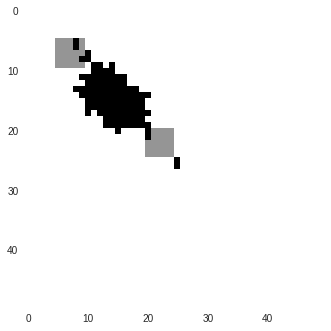

t=190


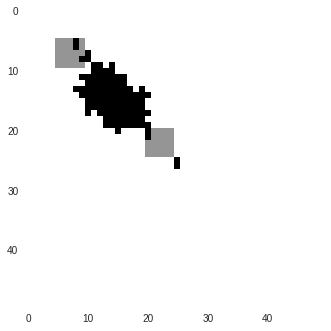

t=191


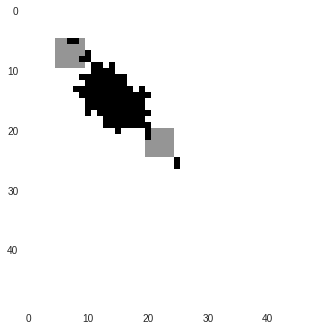

t=192


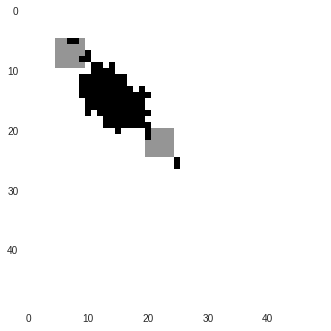

t=193


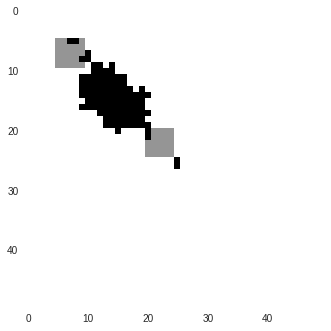

t=194


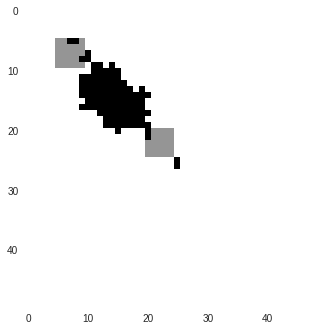

t=195


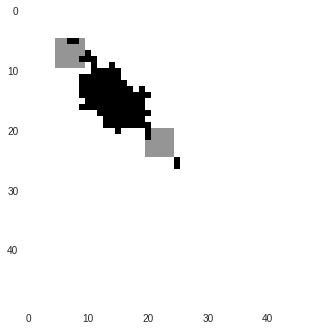

t=196


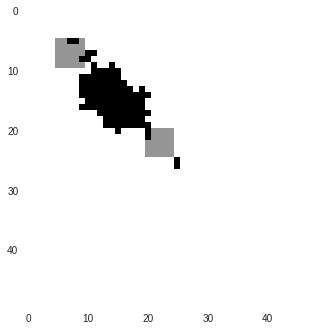

t=197


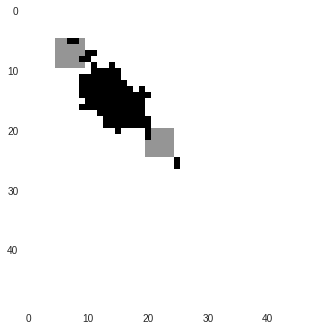

t=198


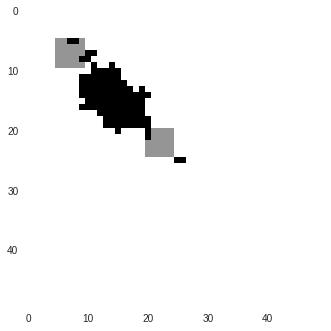

t=199


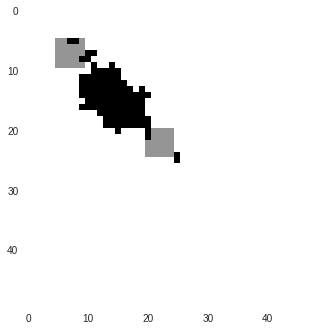

t=200


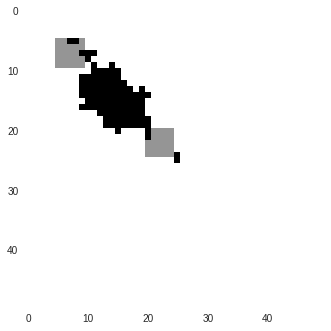

t=201


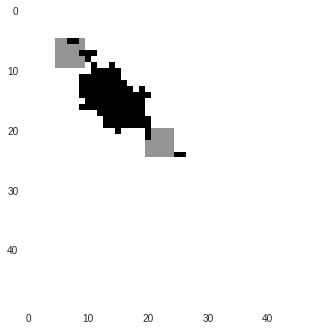

t=202


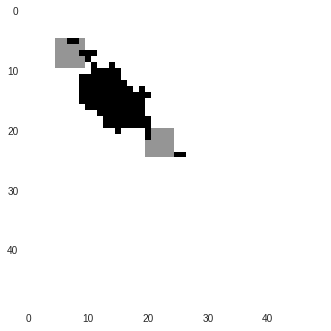

t=203


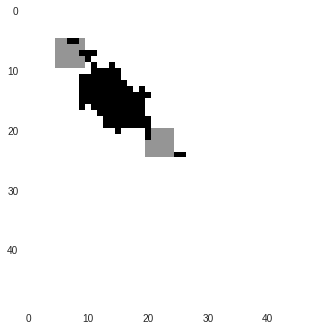

t=204


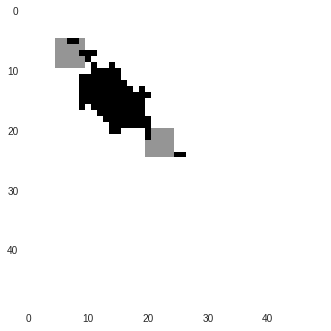

t=205


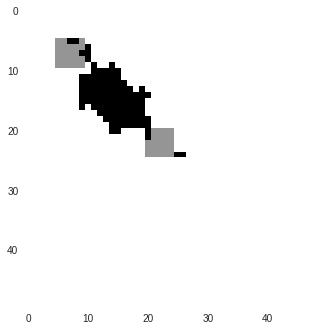

t=206


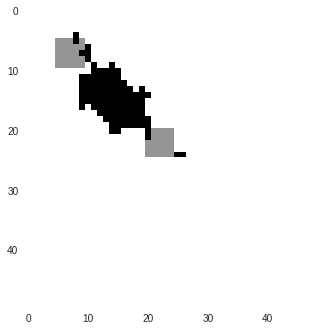

t=207


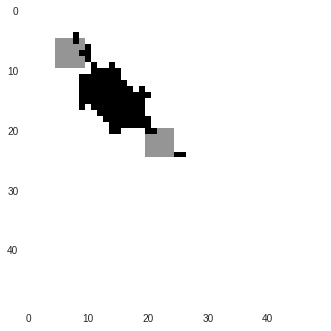

t=208


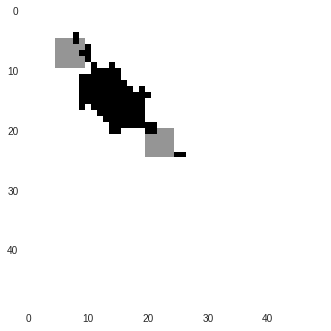

t=209


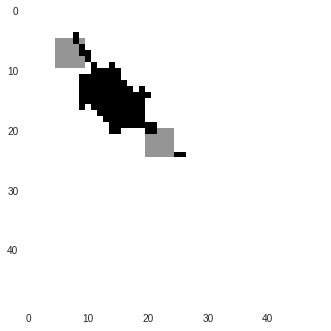

t=210


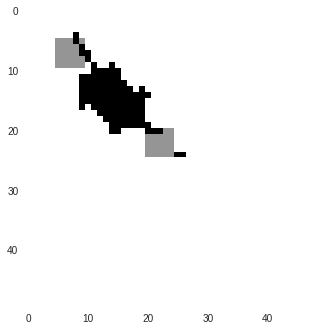

t=211


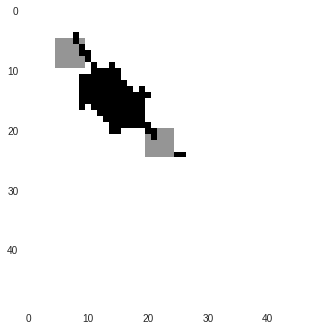

t=212


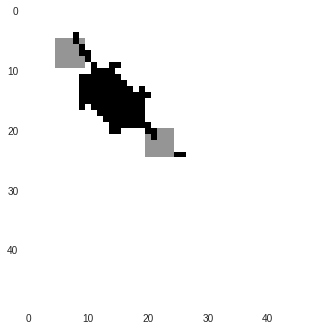

t=213


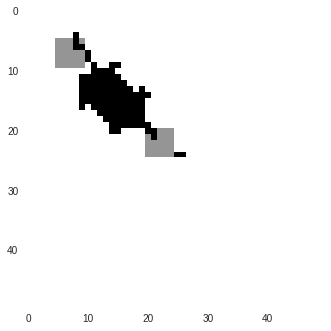

t=214


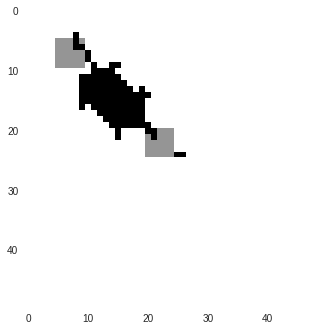

t=215


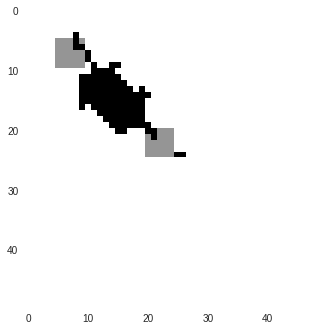

t=216


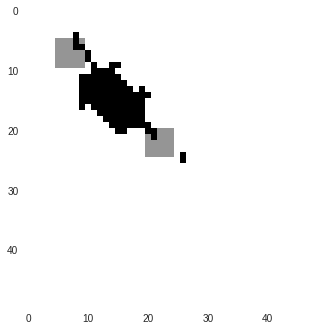

t=217


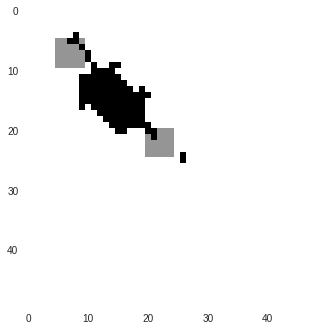

t=218


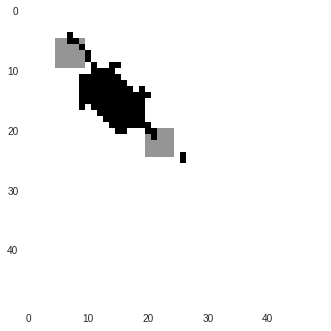

t=219


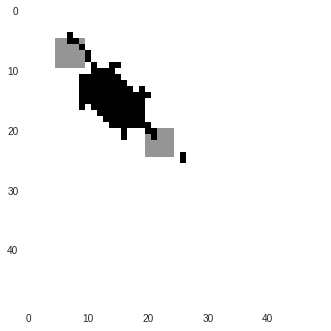

t=220


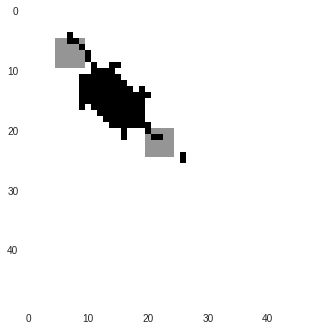

t=221


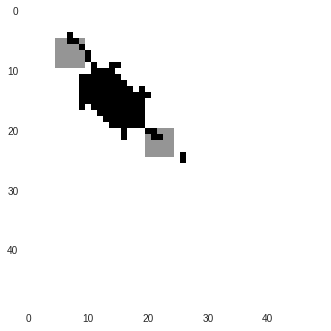

t=222


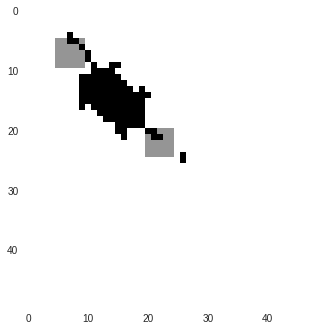

t=223


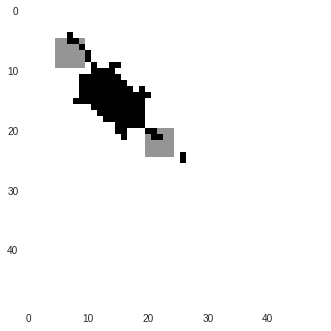

t=224


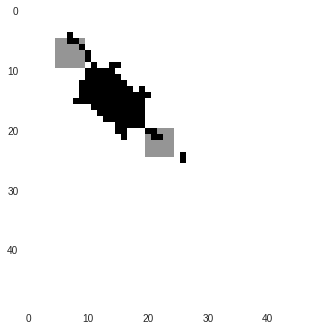

t=225


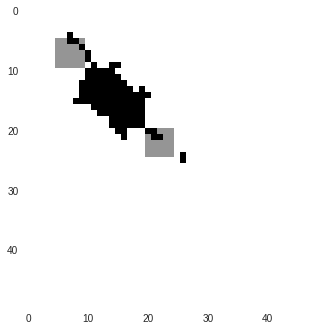

t=226


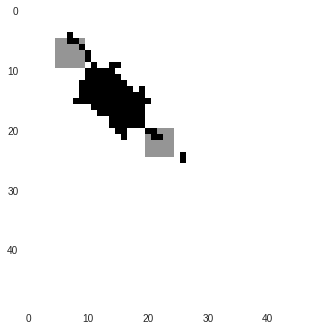

t=227


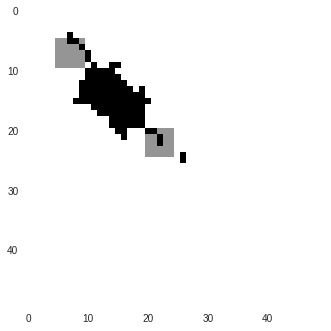

t=228


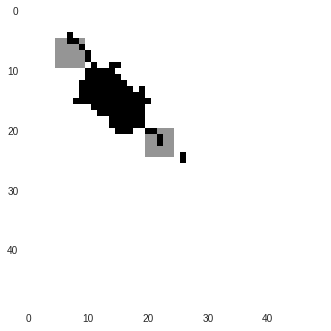

t=229


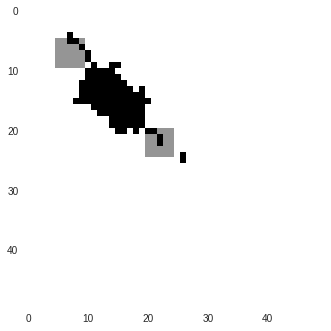

t=230


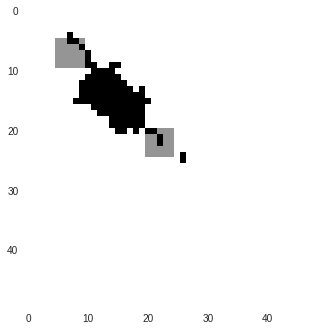

t=231


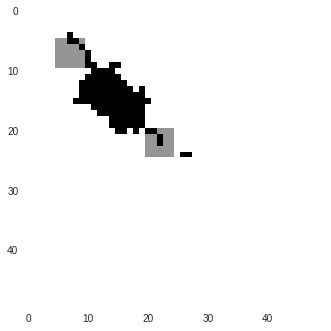

t=232


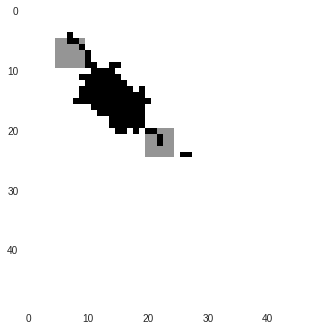

t=233


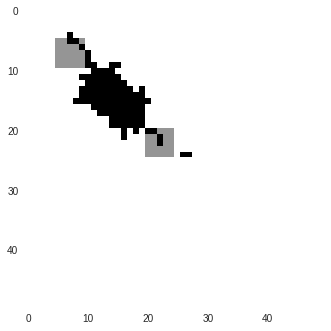

t=234


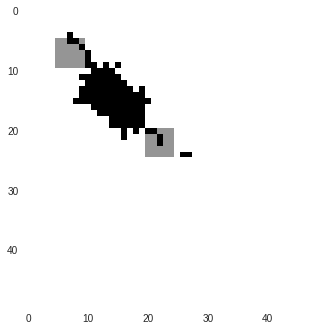

t=235


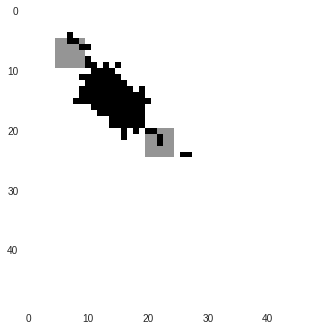

t=236


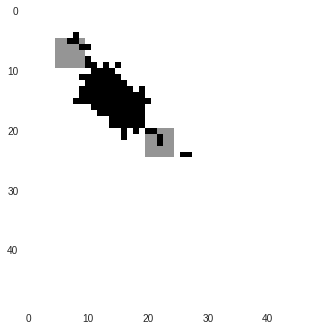

t=237


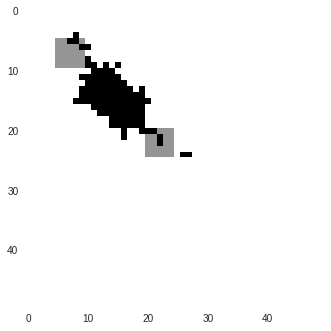

t=238


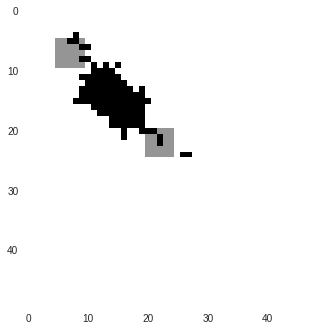

t=239


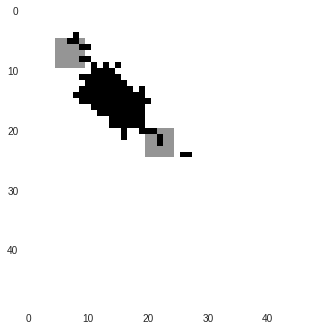

t=240


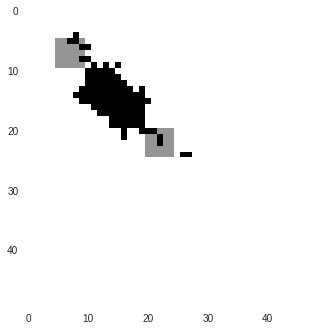

t=241


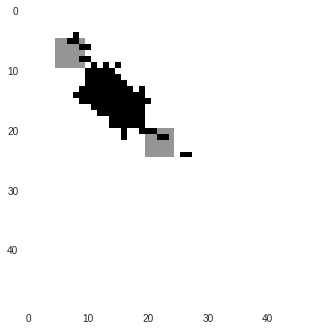

t=242


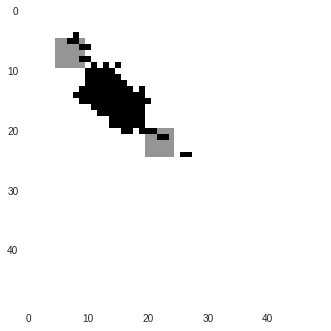

t=243


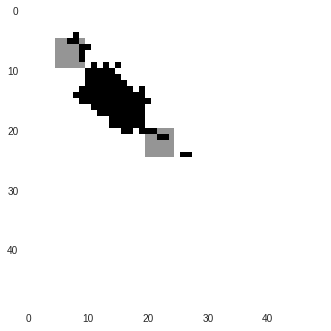

t=244


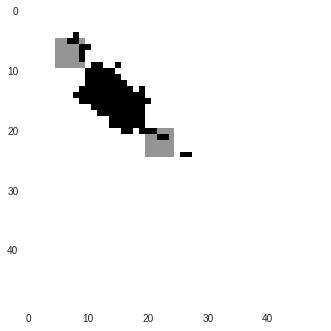

t=245


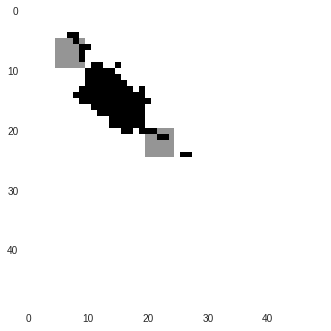

t=246


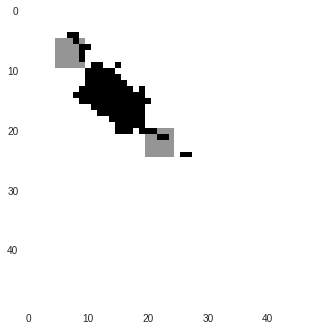

t=247


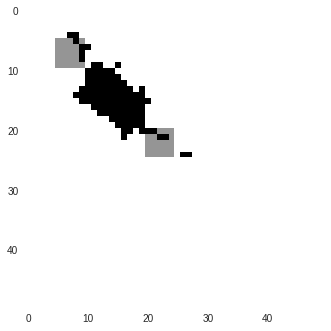

t=248


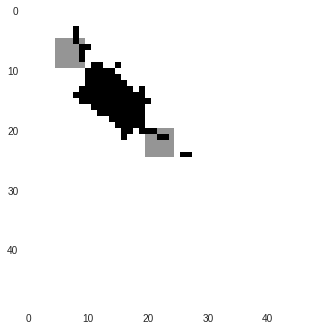

t=249


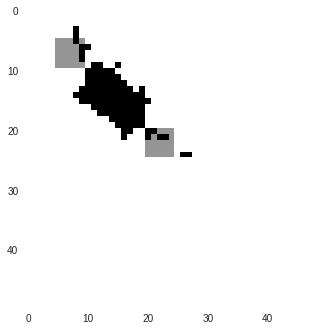

t=250


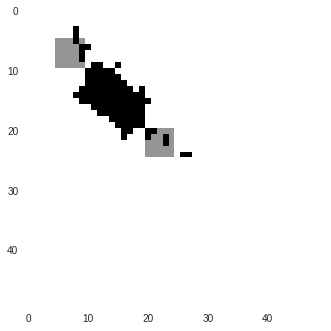

t=251


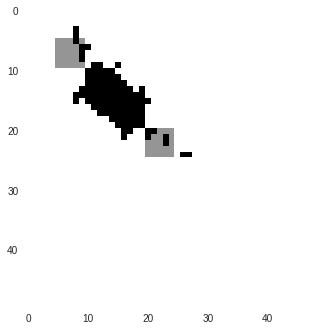

t=252


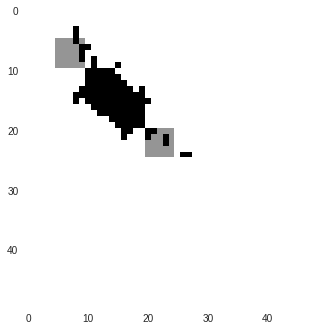

t=253


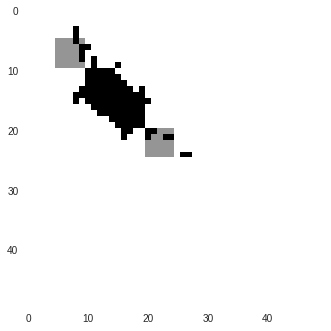

t=254


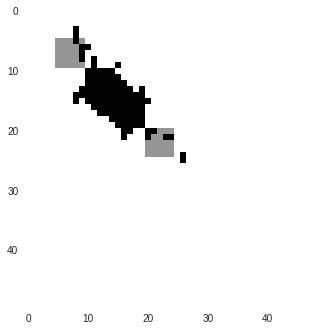

t=255


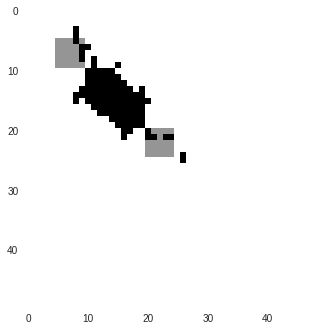

t=256


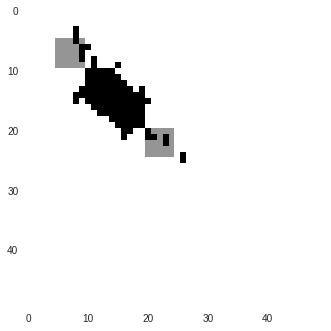

t=257


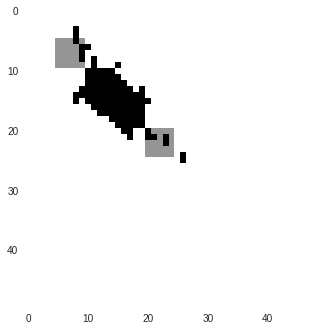

t=258


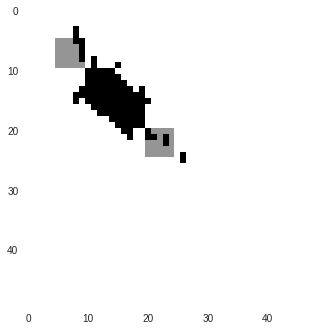

t=259


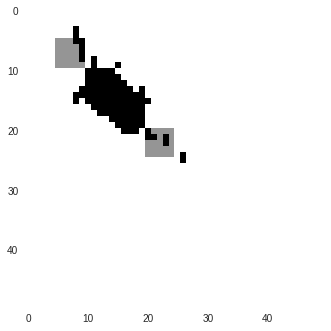

t=260


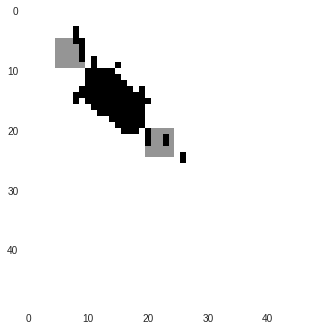

t=261


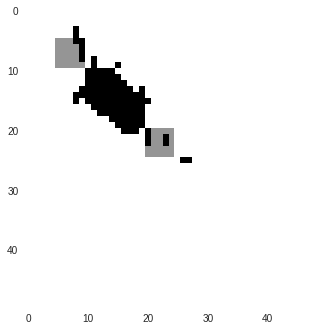

t=262


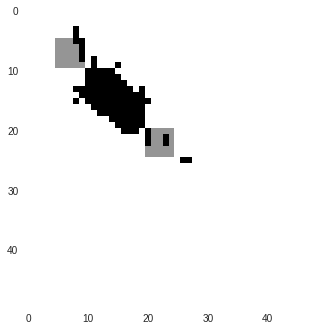

t=263


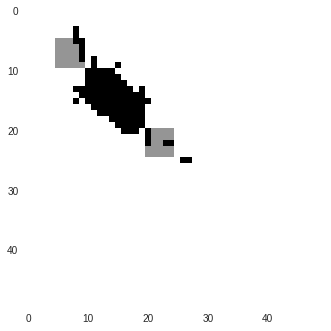

t=264


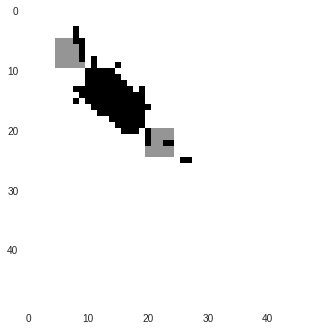

t=265


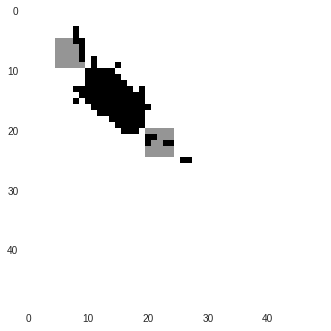

t=266


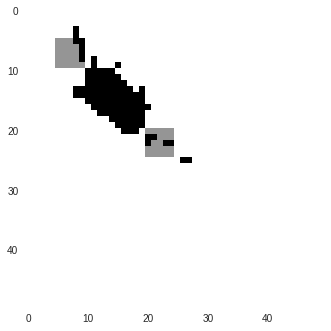

t=267


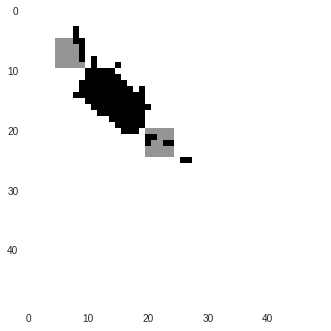

t=268


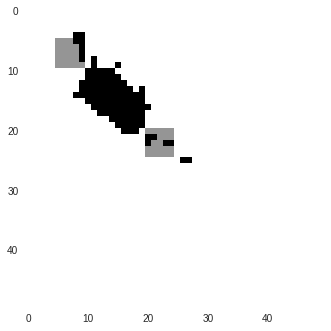

t=269


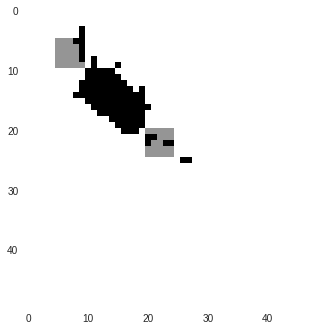

t=270


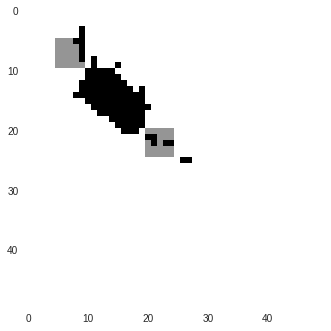

t=271


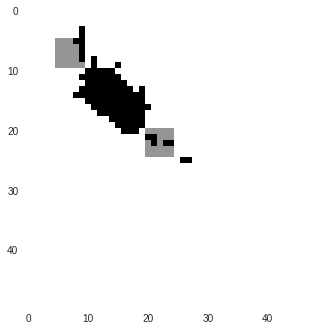

t=272


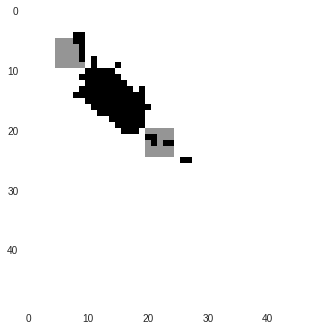

t=273


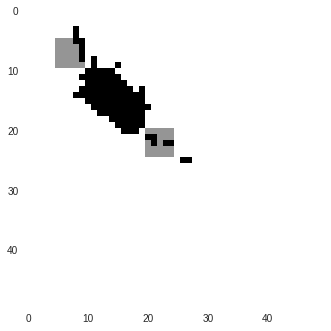

t=274


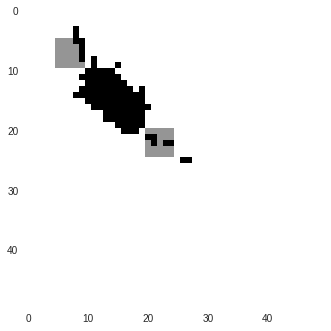

t=275


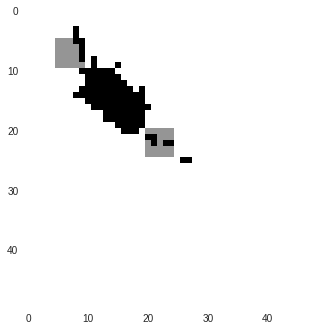

t=276


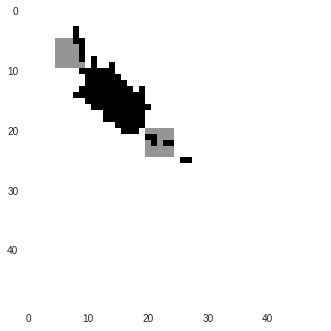

t=277


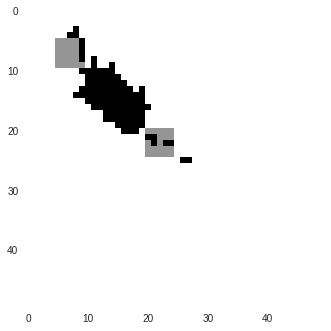

t=278


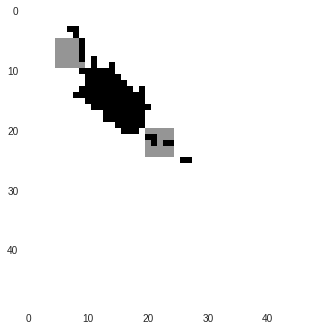

t=279


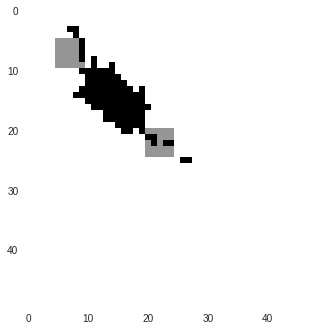

t=280


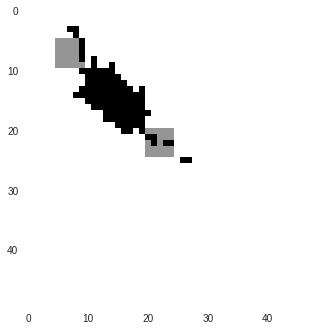

t=281


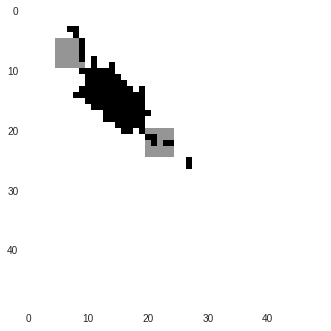

t=282


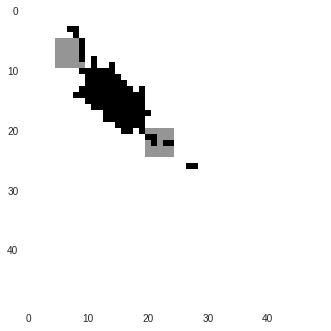

t=283


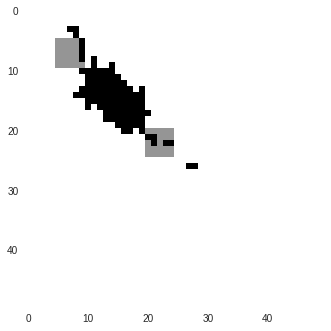

t=284


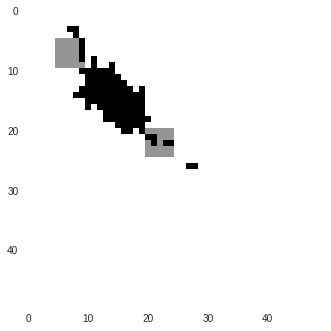

t=285


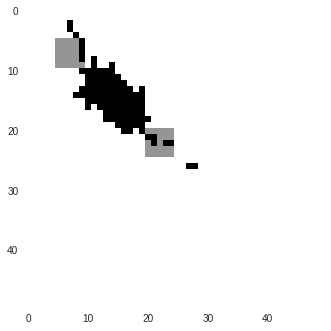

t=286


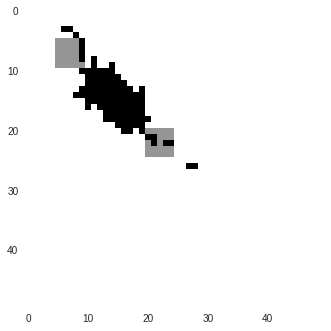

t=287


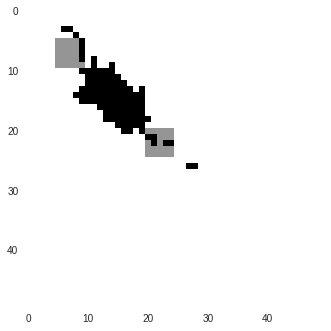

t=288


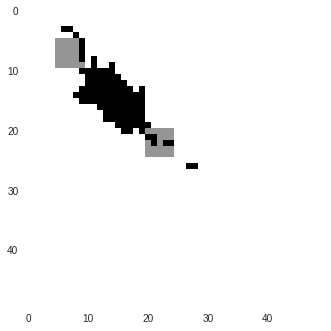

t=289


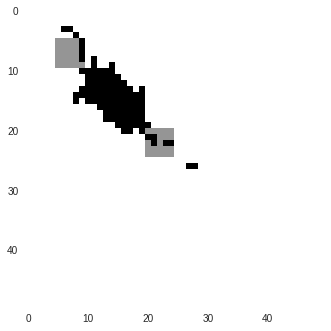

t=290


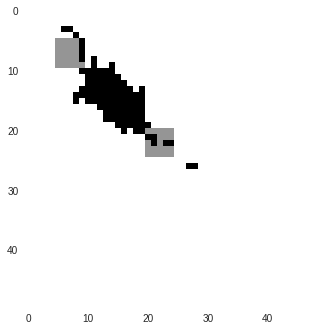

t=291


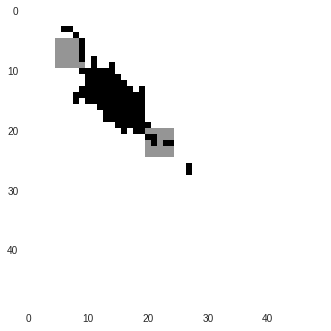

t=292


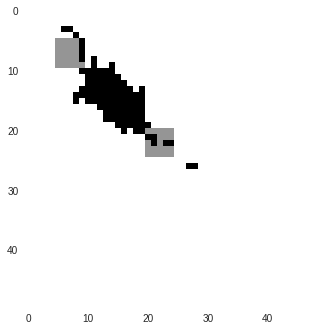

t=293


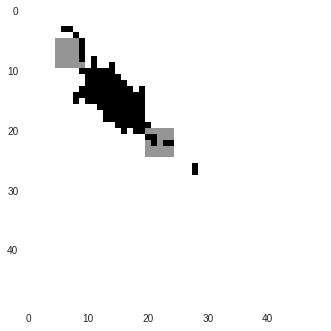

t=294


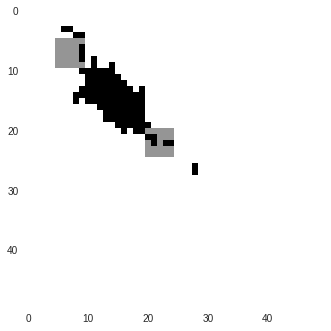

t=295


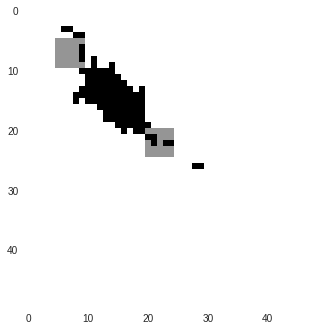

t=296


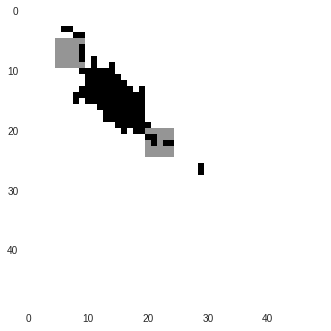

t=297


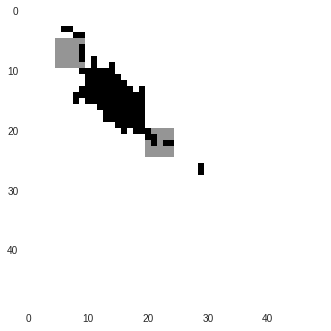

t=298


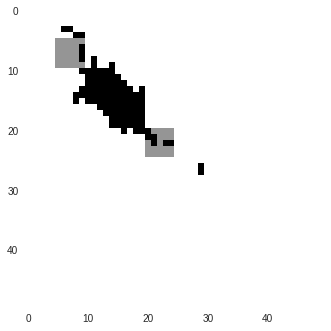

t=299


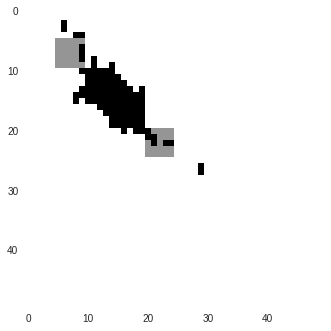

t=300


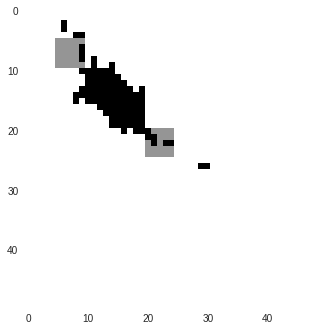

t=301


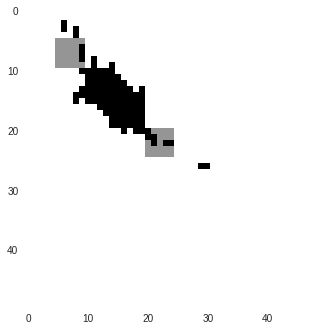

t=302


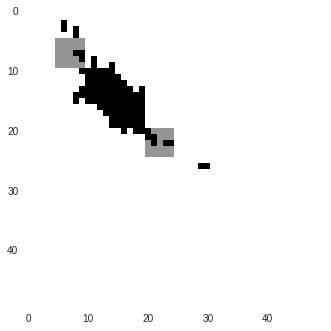

t=303


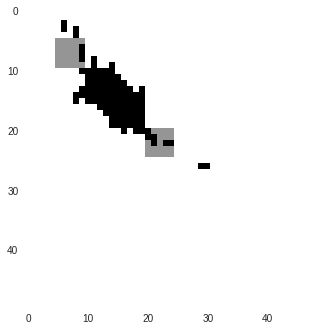

t=304


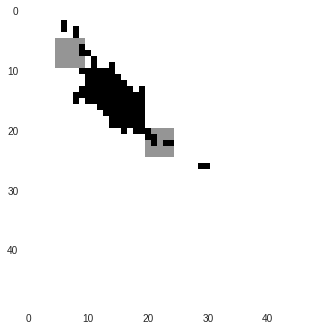

t=305


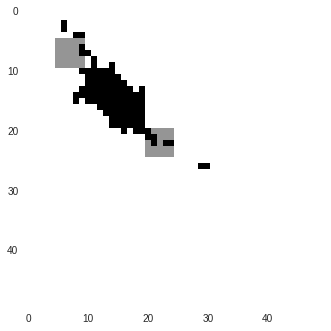

t=306


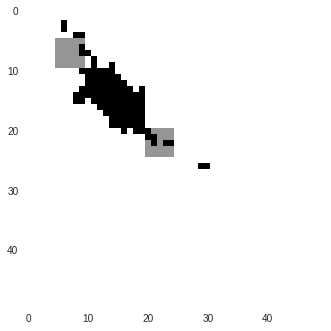

t=307


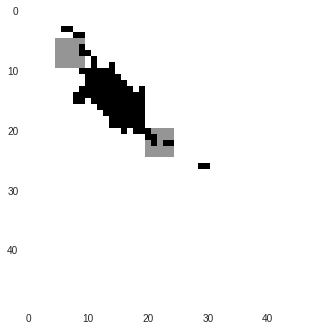

t=308


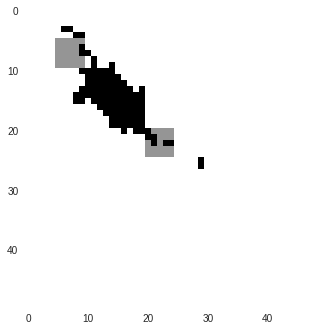

t=309


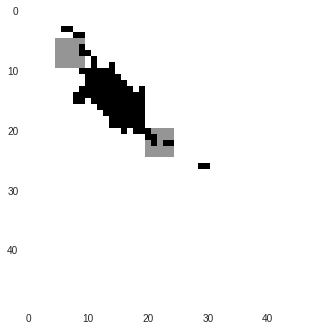

t=310


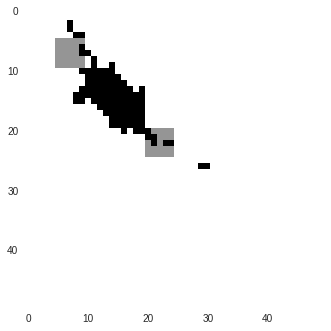

t=311


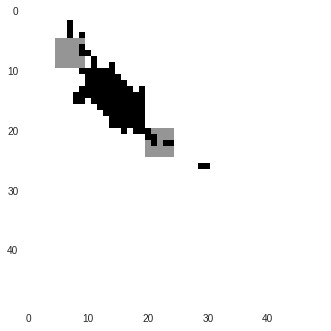

t=312


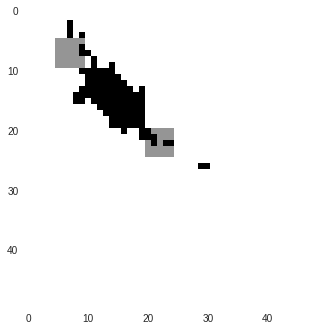

t=313


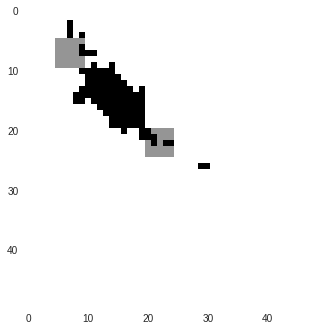

t=314


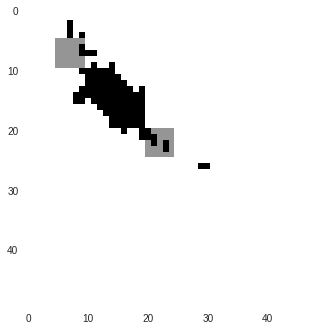

t=315


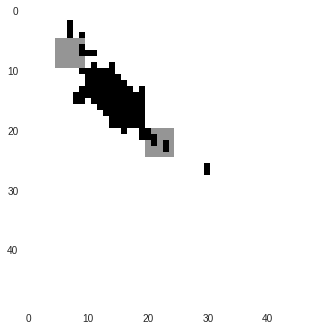

t=316


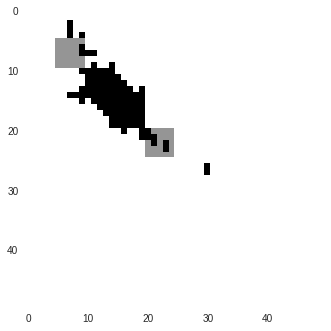

t=317


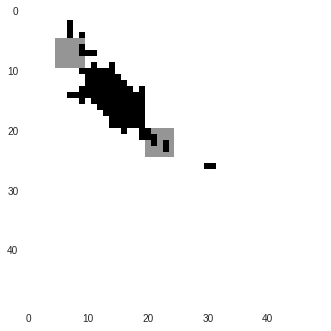

t=318


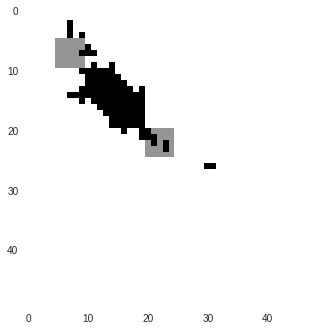

t=319


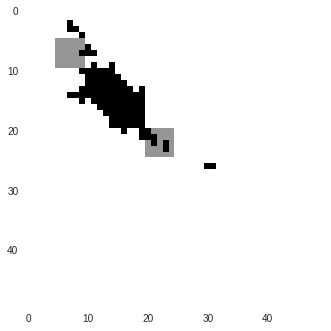

t=320


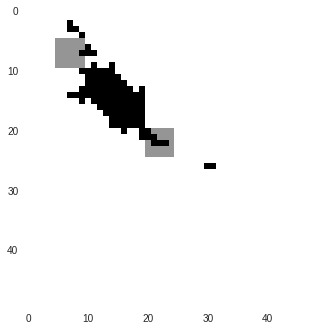

t=321


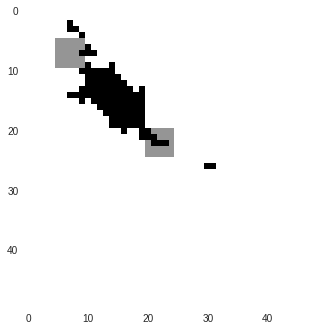

t=322


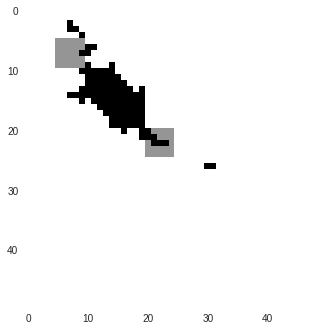

t=323


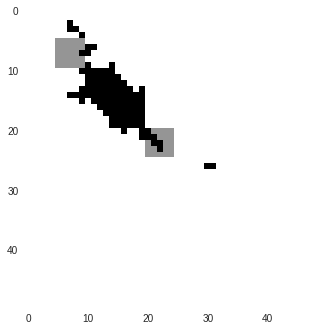

t=324


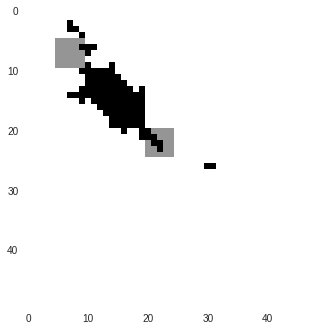

t=325


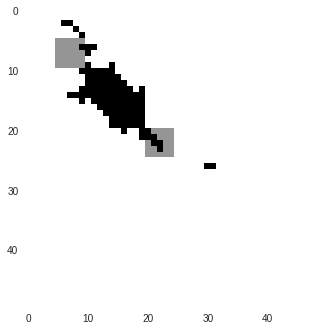

t=326


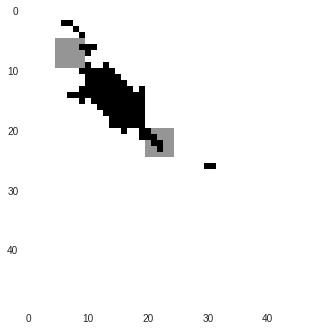

t=327


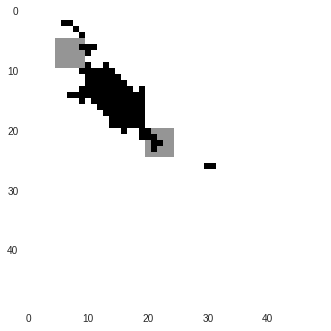

t=328


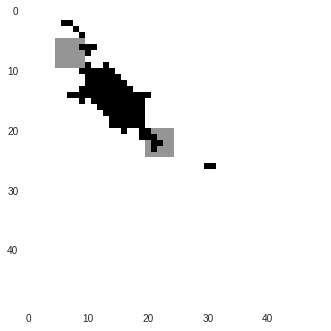

t=329


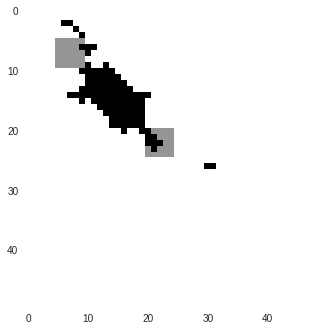

t=330


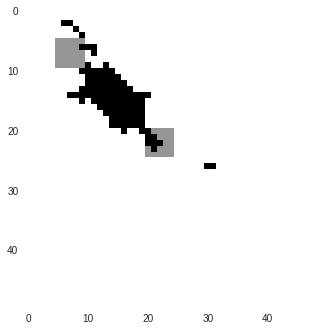

t=331


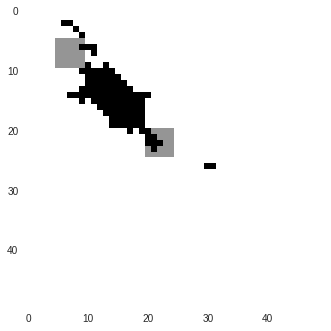

t=332


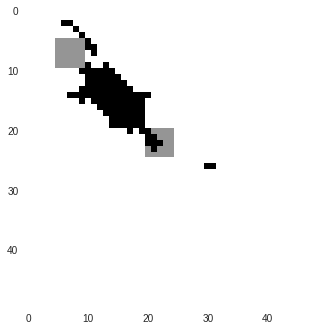

t=333


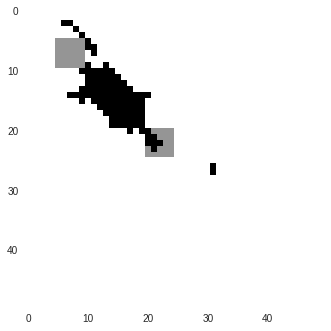

t=334


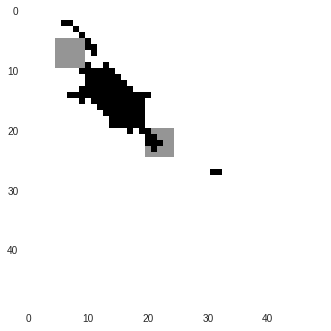

t=335


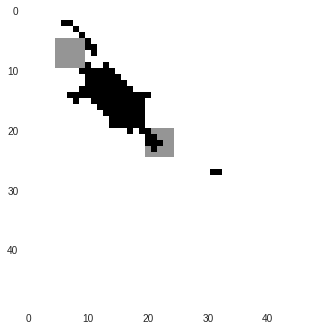

t=336


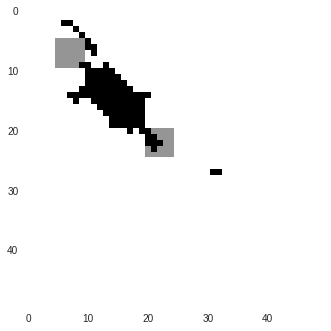

t=337


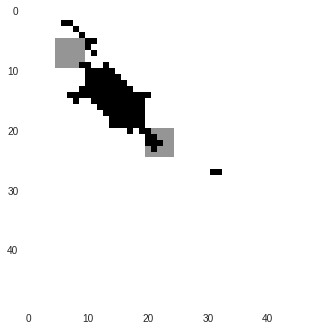

t=338


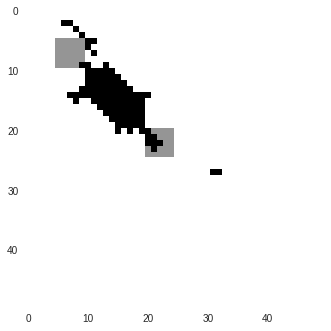

t=339


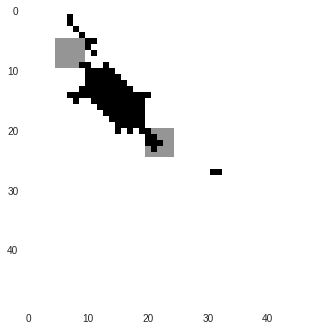

t=340


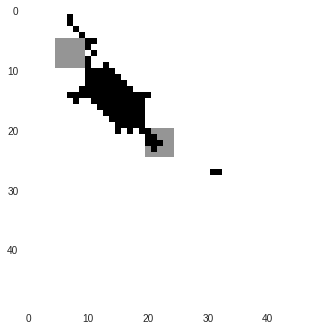

t=341


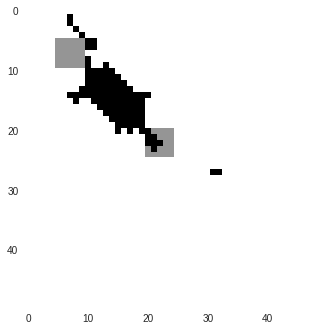

t=342


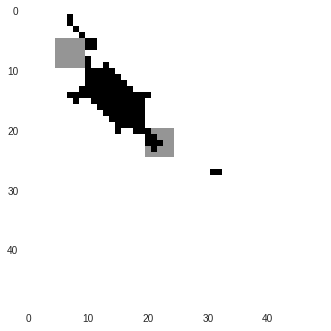

t=343


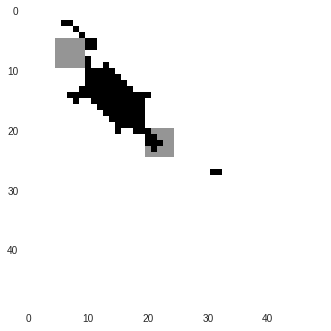

t=344


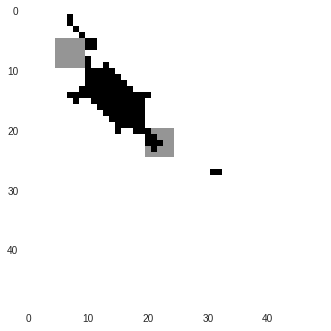

t=345


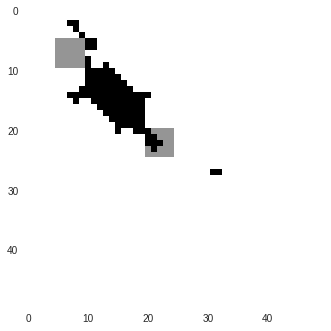

t=346


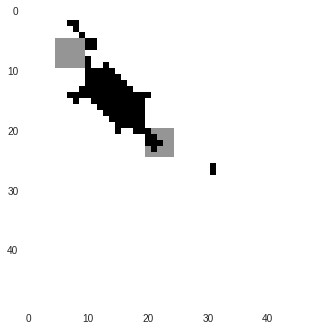

t=347


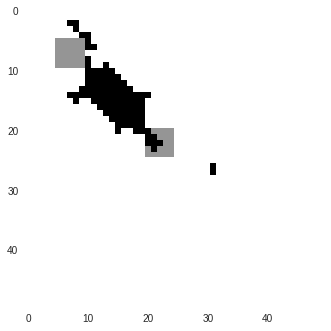

t=348


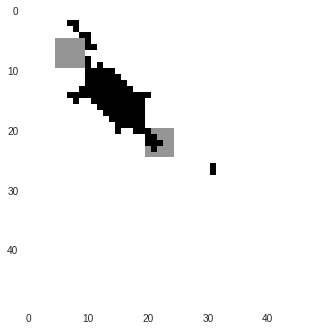

t=349


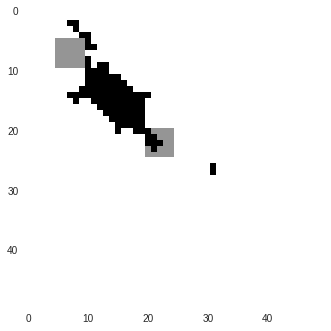

t=350


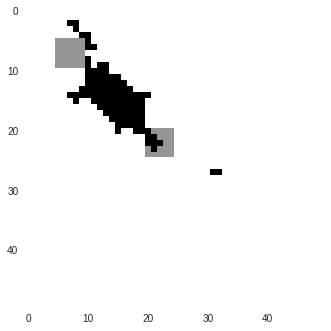

t=351


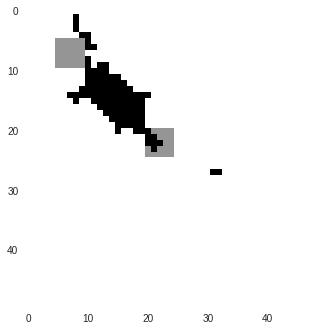

t=352


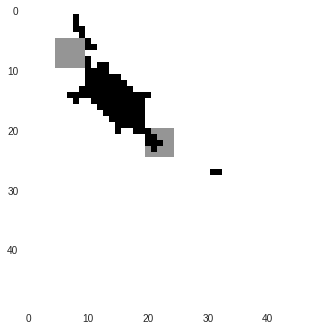

t=353


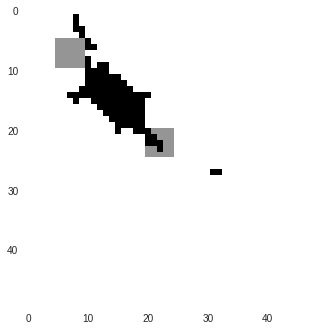

t=354


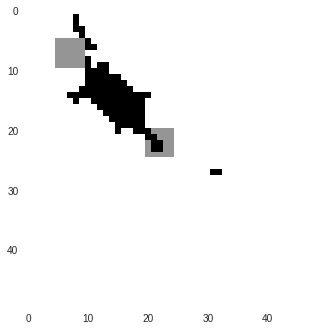

t=355


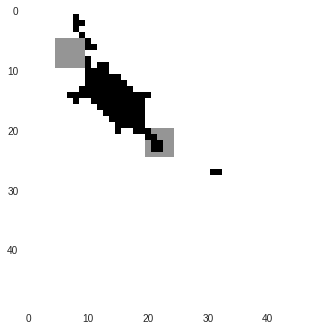

t=356


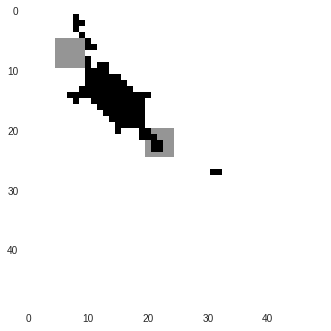

t=357


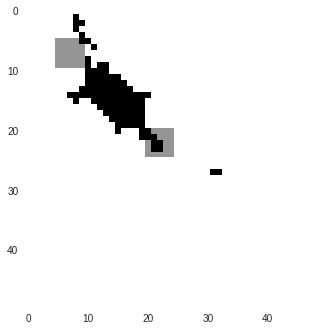

t=358


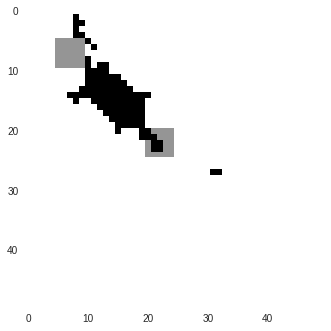

t=359


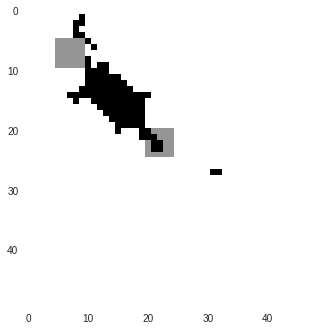

t=360


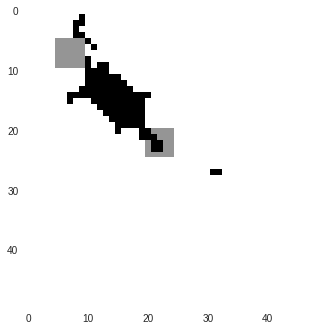

t=361


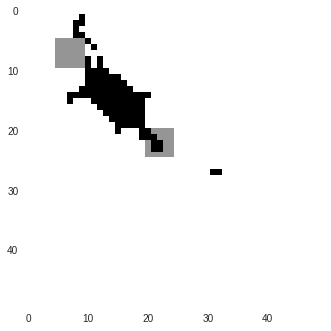

t=362


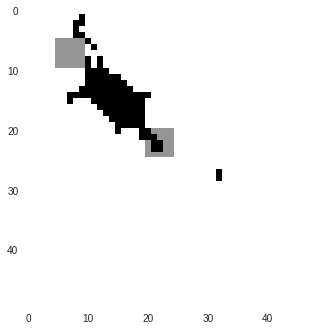

t=363


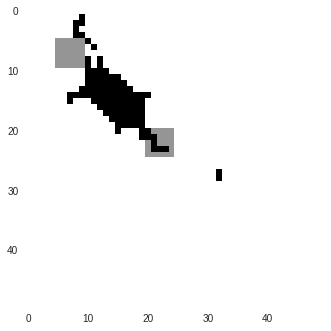

t=364


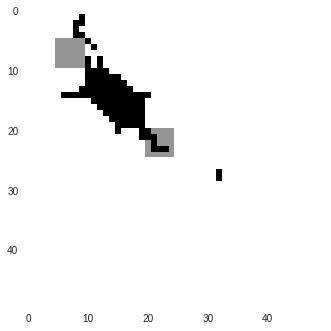

t=365


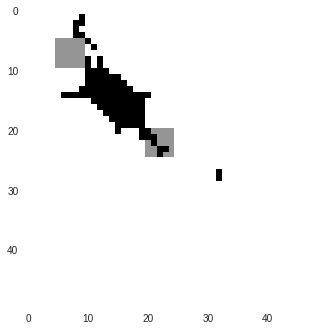

t=366


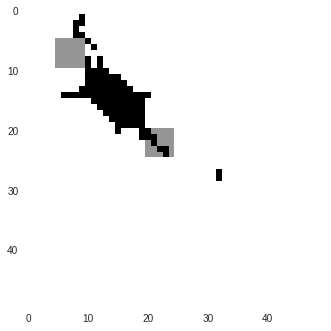

t=367


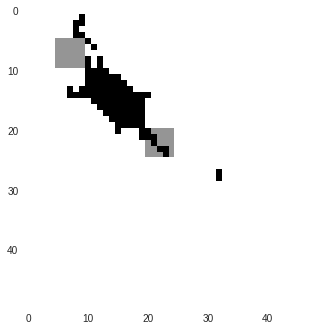

t=368


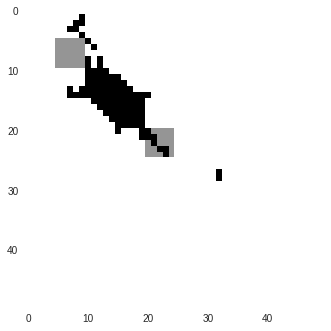

t=369


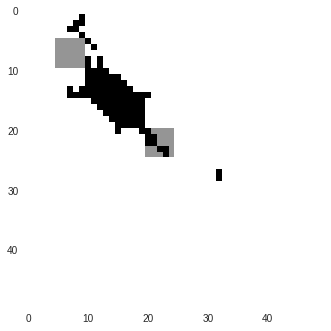

t=370


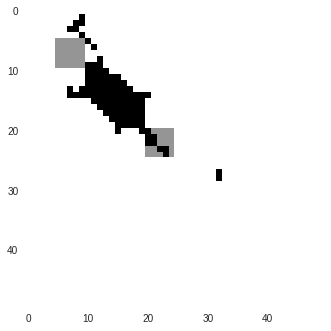

t=371


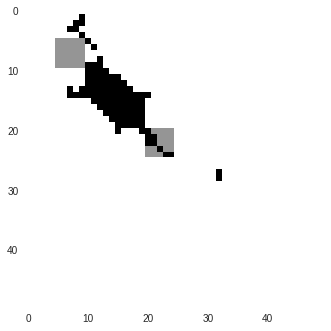

t=372


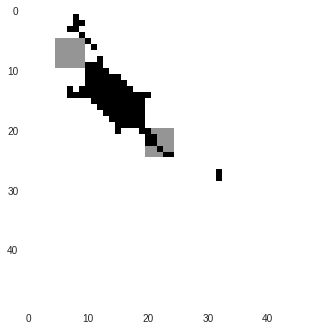

t=373


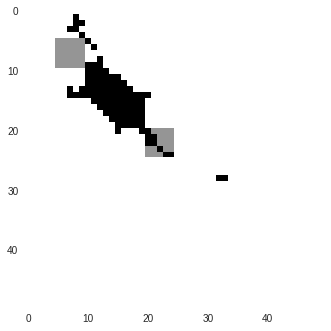

t=374


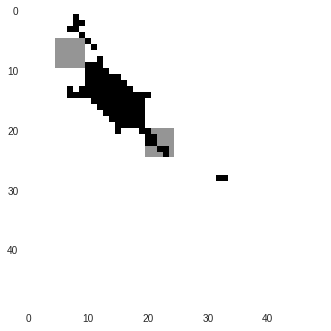

t=375


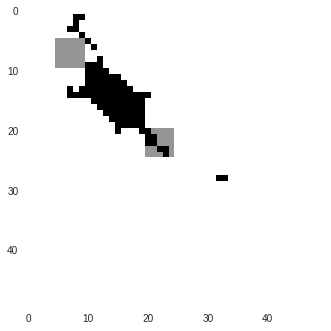

t=376


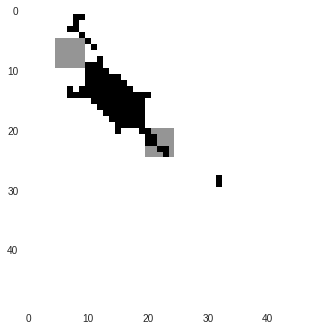

t=377


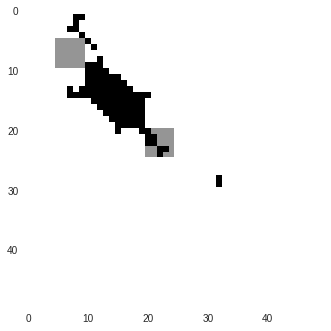

t=378


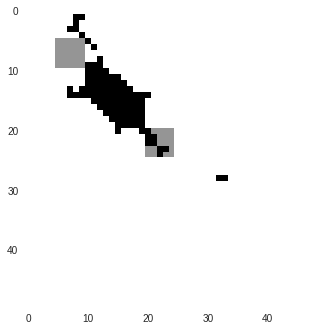

t=379


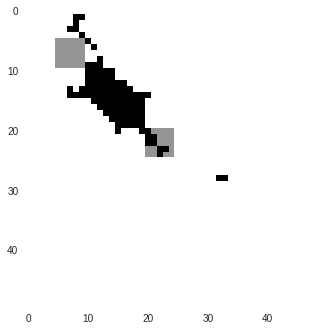

t=380


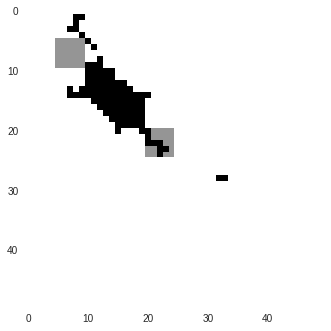

t=381


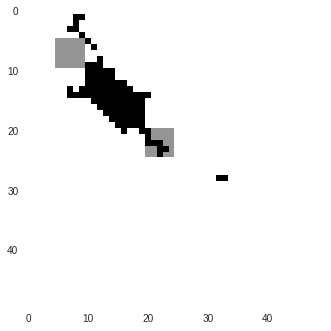

t=382


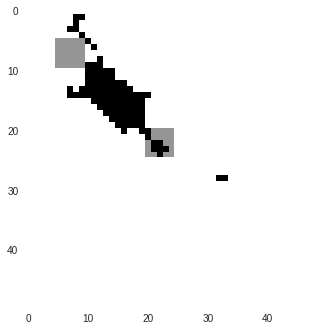

t=383


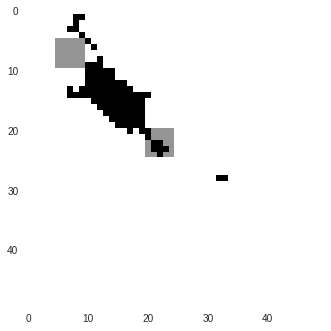

t=384


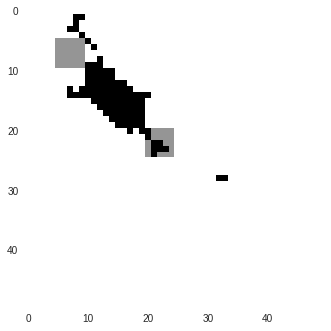

t=385


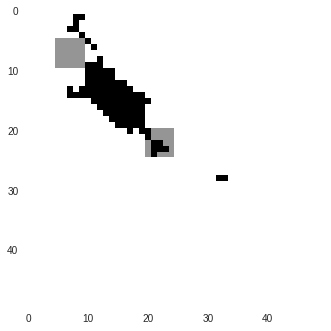

t=386


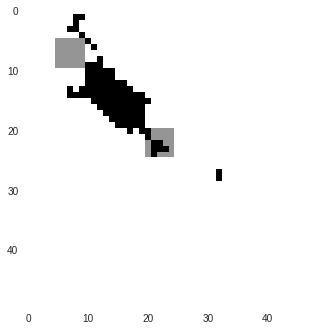

t=387


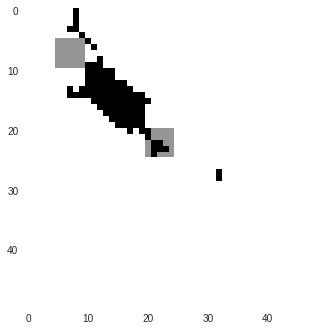

t=388


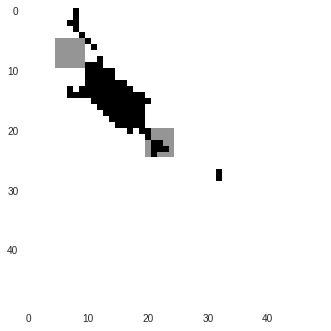

t=389


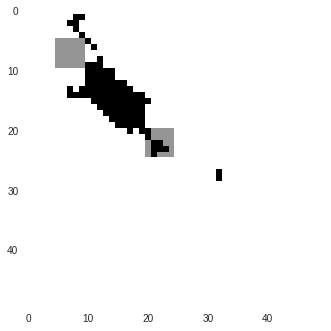

t=390


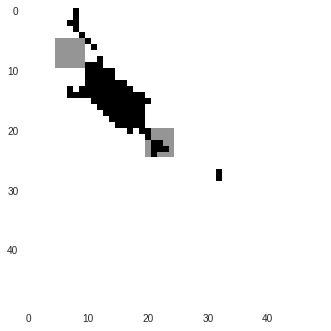

t=391


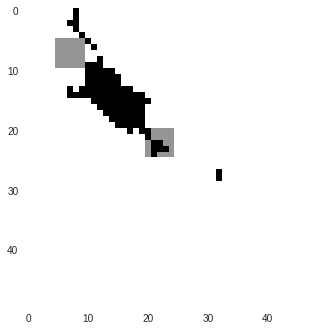

t=392


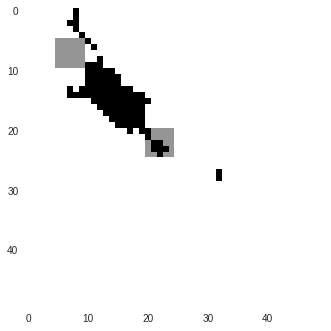

t=393


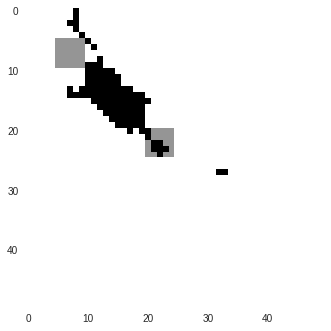

t=394


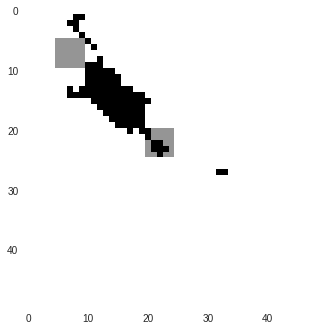

t=395


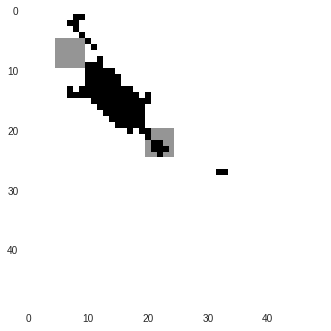

t=396


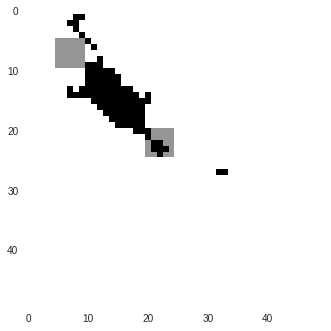

t=397


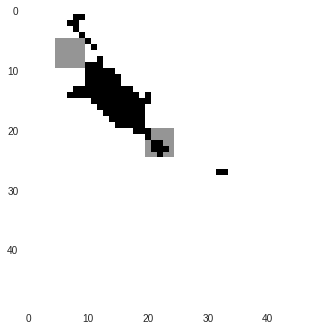

t=398


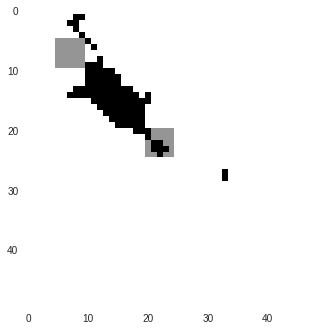

t=399


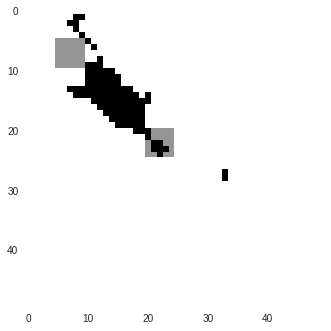

t=400


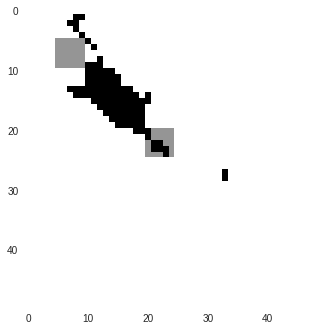

t=401


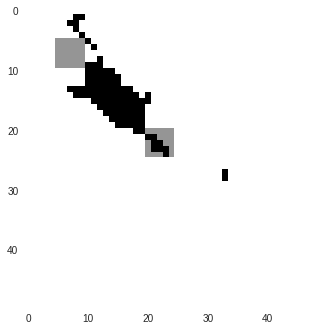

t=402


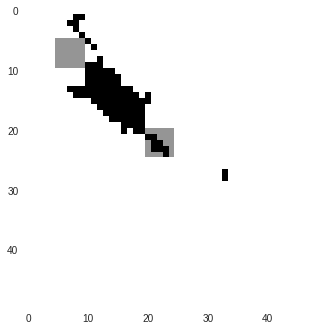

t=403


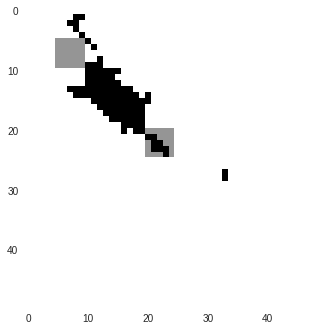

t=404


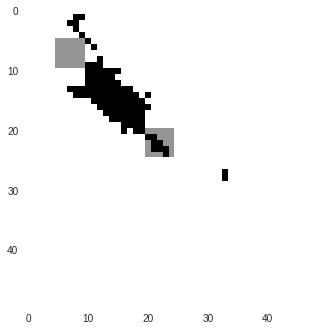

t=405


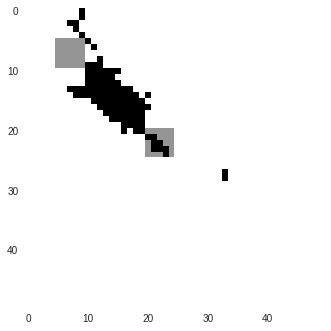

t=406


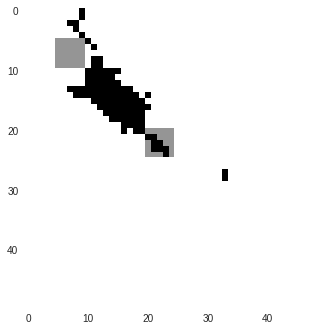

t=407


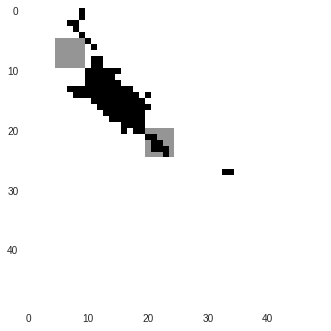

t=408


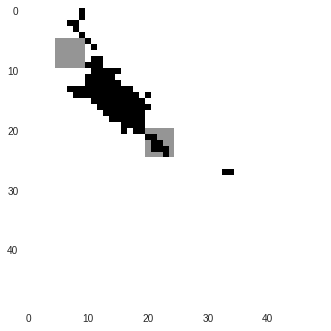

t=409


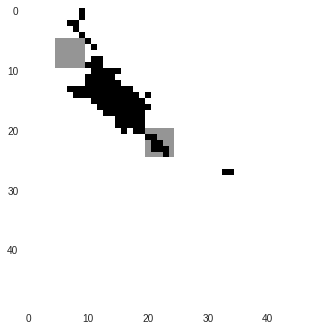

t=410


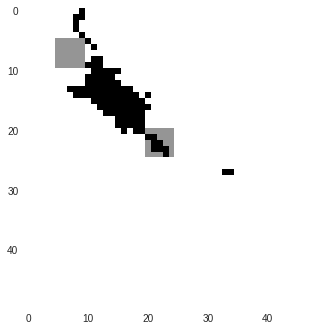

t=411


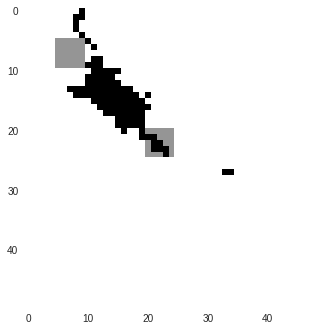

t=412


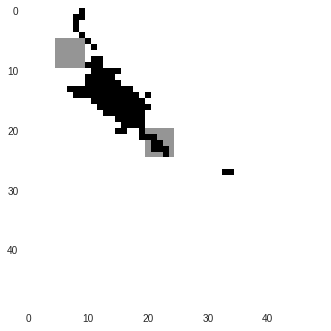

t=413


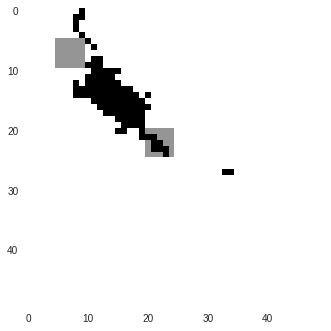

t=414


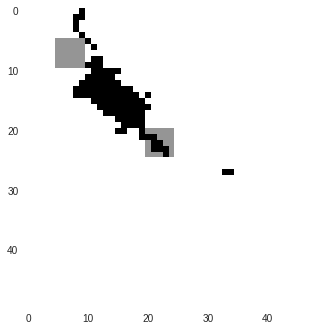

t=415


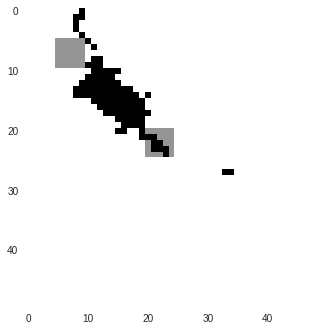

t=416


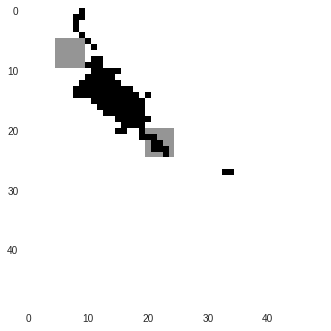

t=417


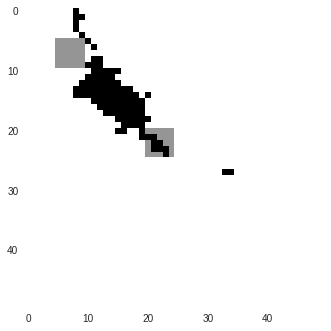

t=418


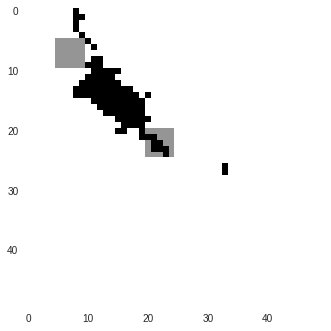

t=419


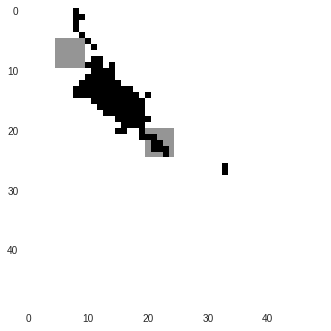

t=420


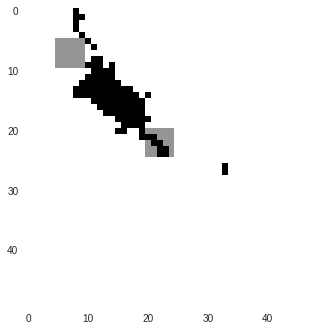

t=421


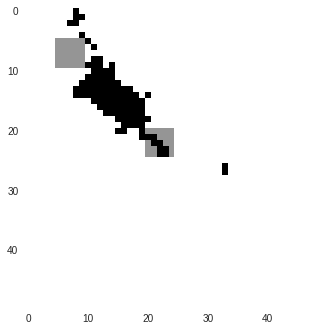

t=422


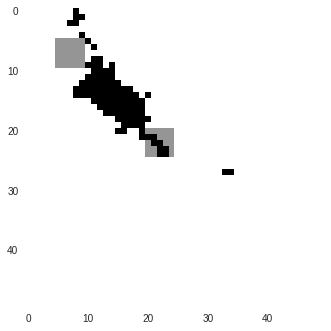

t=423


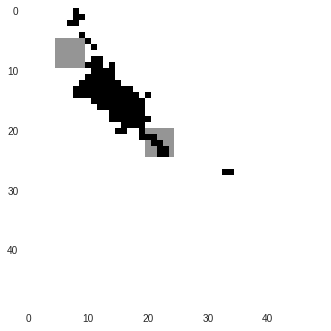

t=424


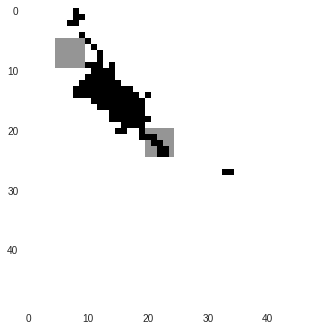

t=425


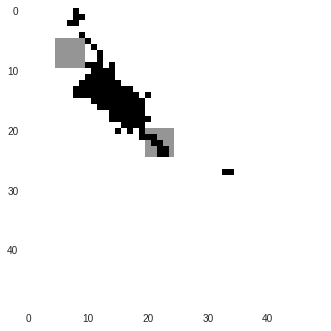

t=426


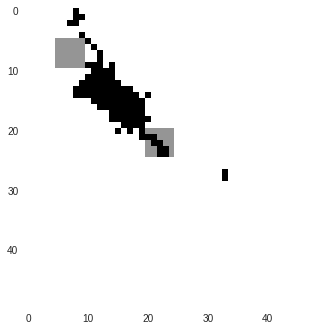

t=427


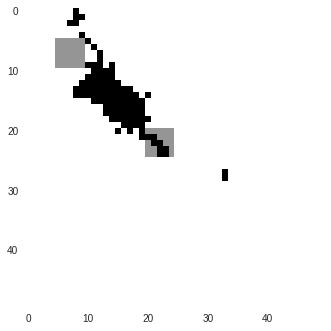

t=428


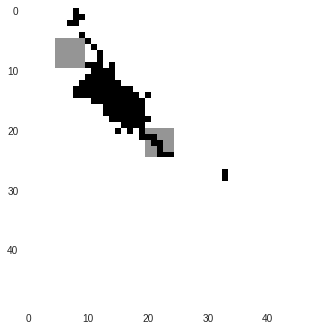

t=429


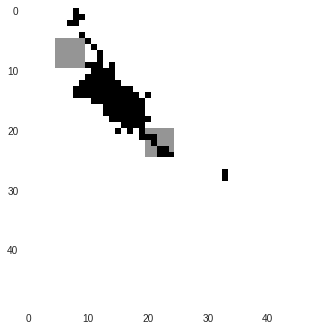

t=430


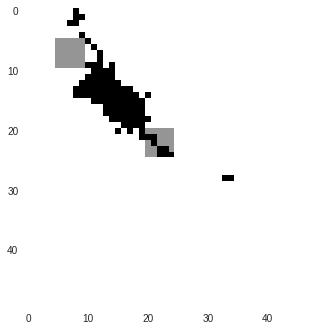

t=431


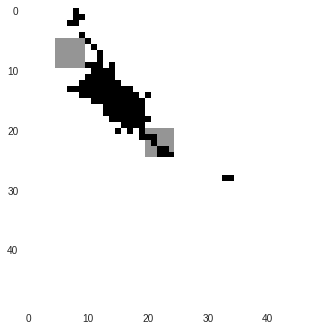

t=432


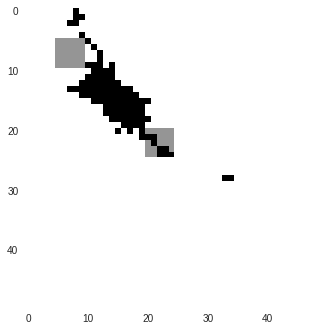

t=433


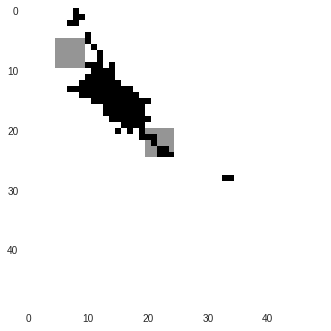

t=434


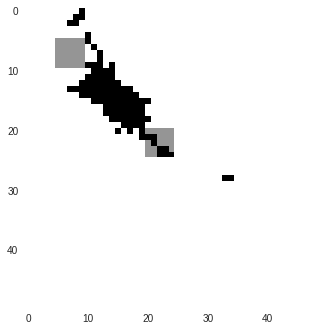

t=435


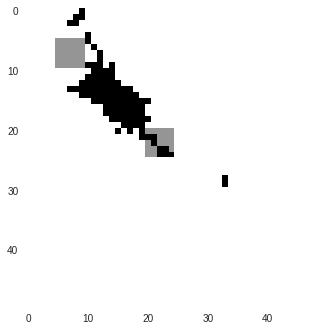

t=436


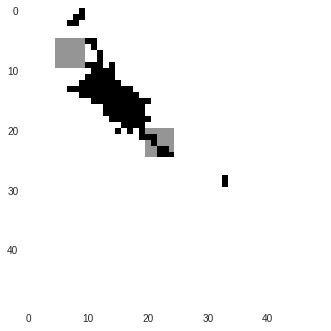

t=437


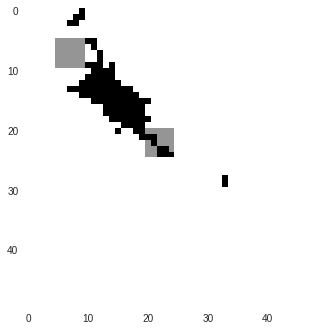

t=438


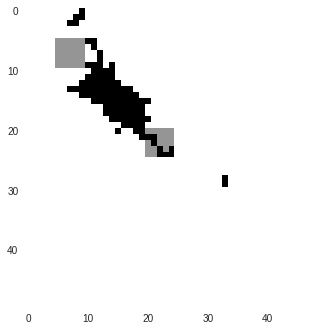

t=439


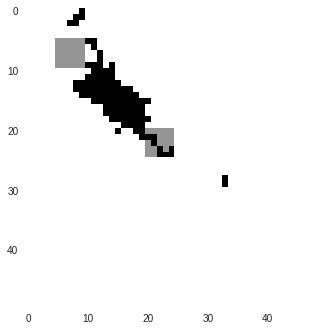

t=440


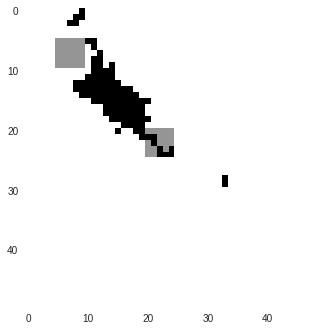

t=441


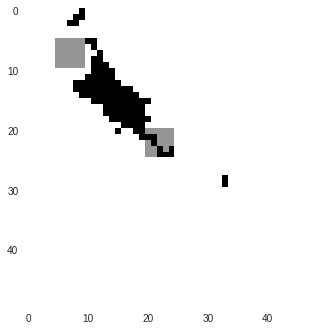

t=442


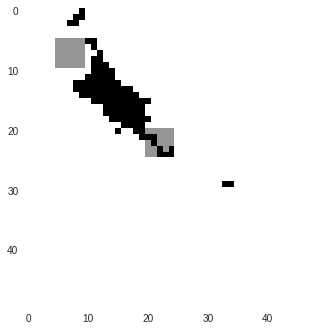

t=443


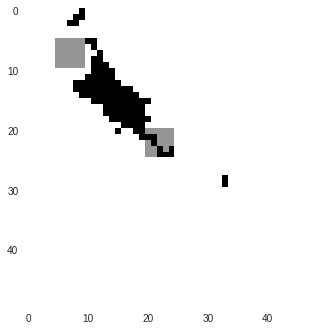

t=444


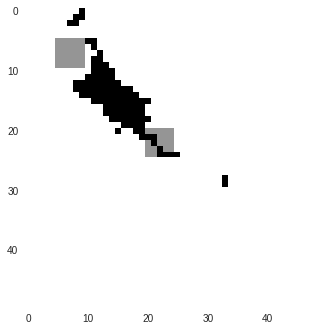

t=445


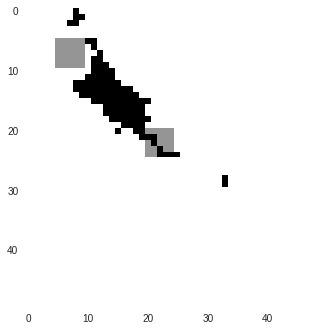

t=446


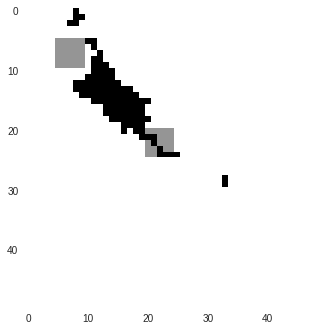

t=447


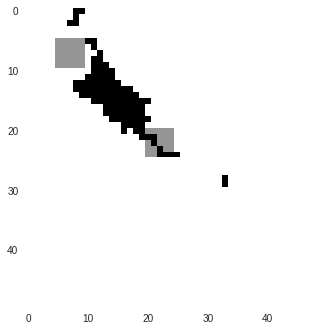

t=448


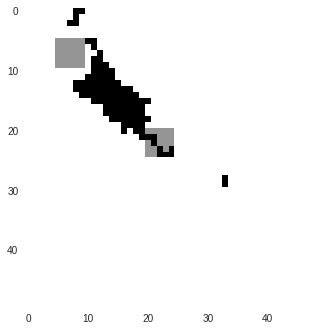

t=449


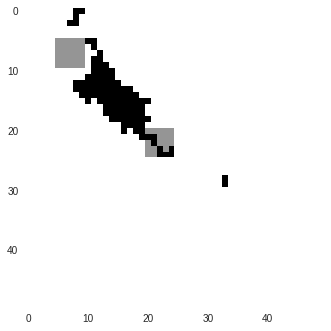

t=450


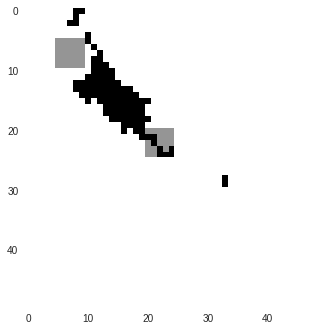

t=451


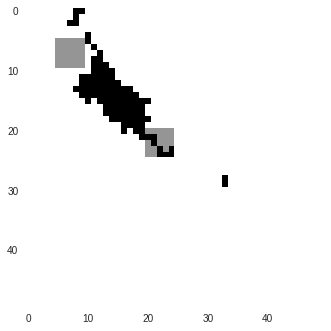

t=452


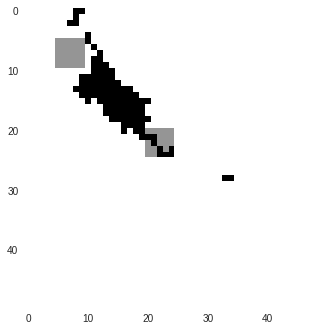

t=453


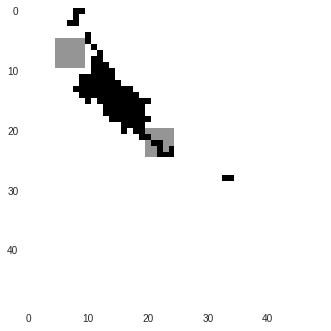

t=454


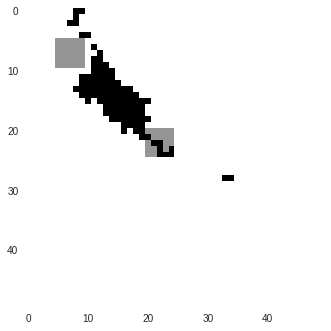

t=455


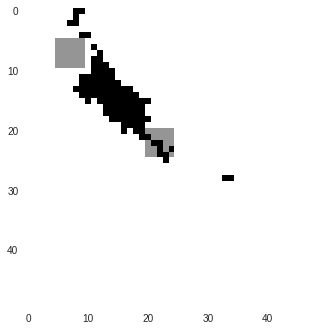

t=456


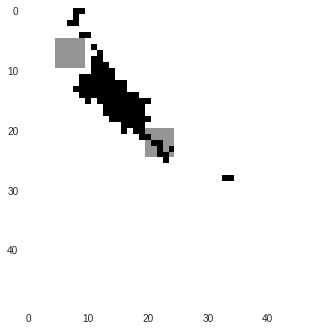

t=457


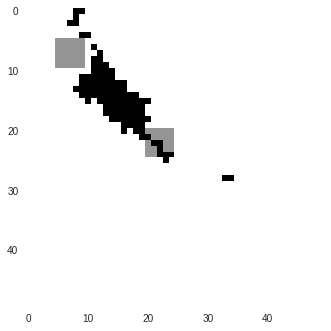

t=458


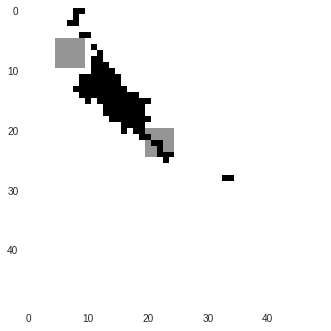

t=459


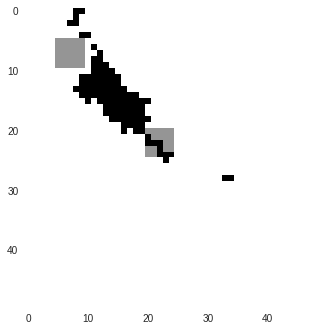

t=460


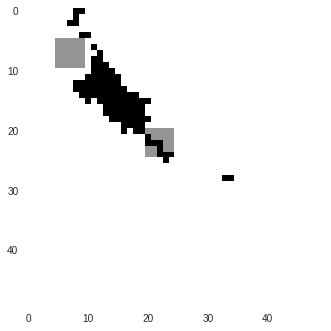

t=461


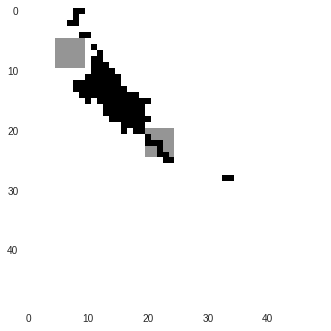

t=462


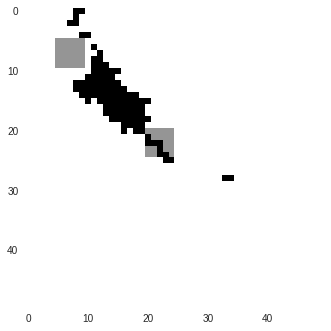

t=463


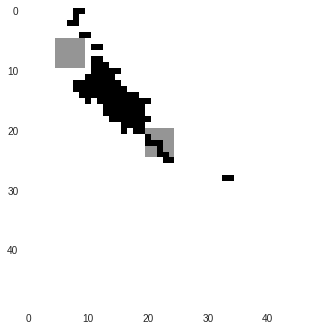

t=464


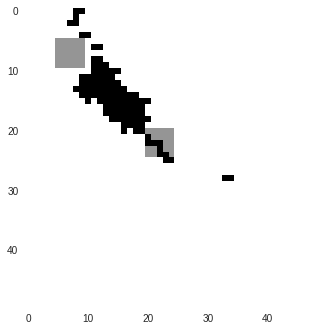

t=465


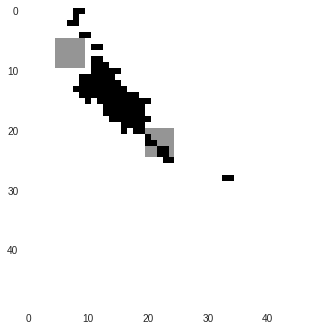

t=466


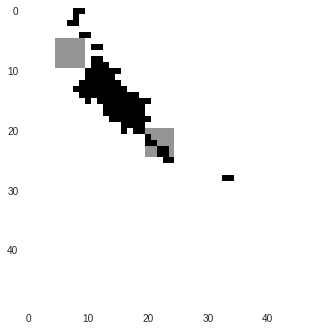

t=467


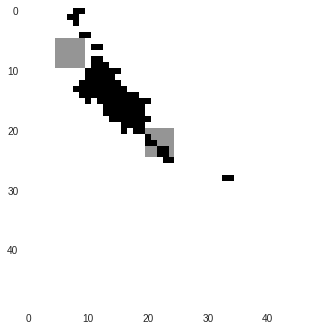

t=468


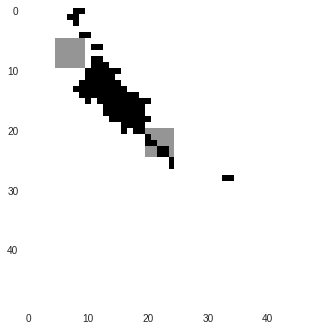

t=469


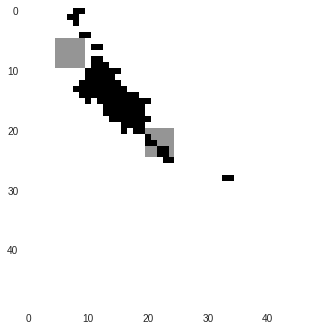

t=470


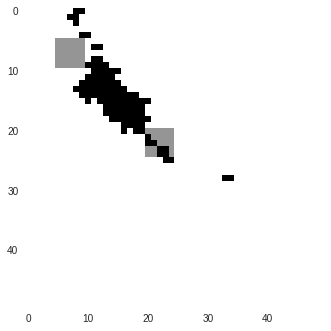

t=471


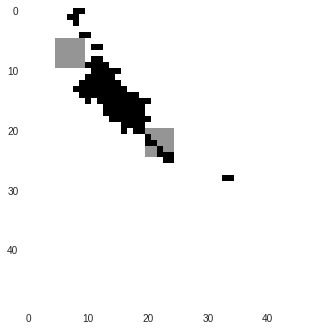

t=472


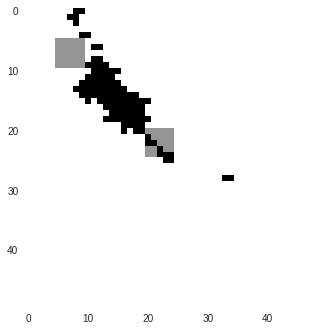

t=473


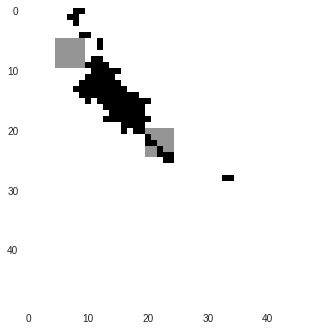

t=474


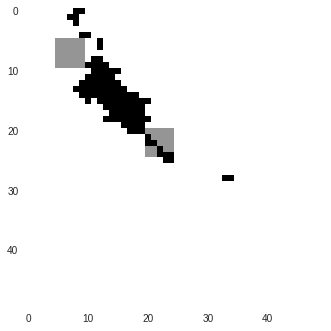

t=475


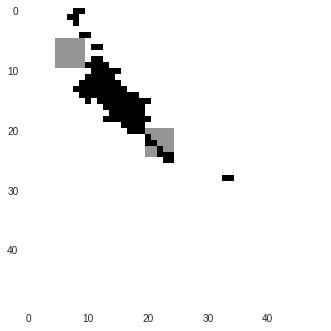

t=476


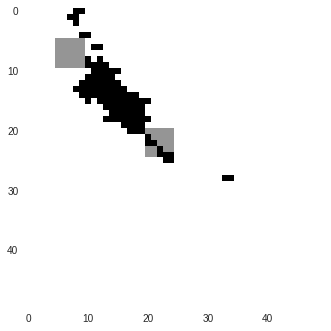

t=477


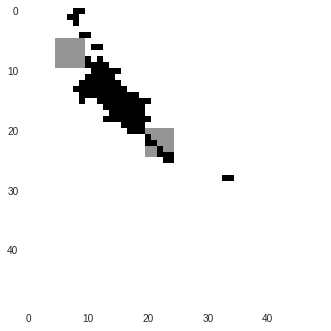

t=478


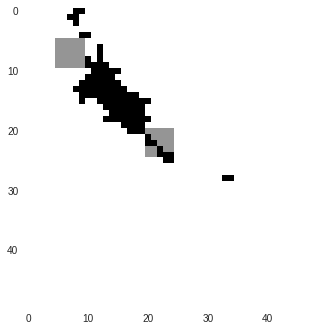

t=479


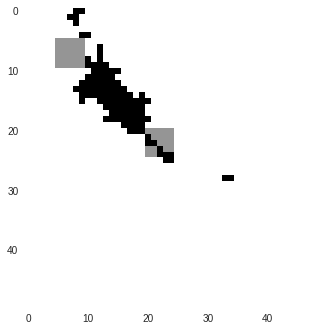

t=480


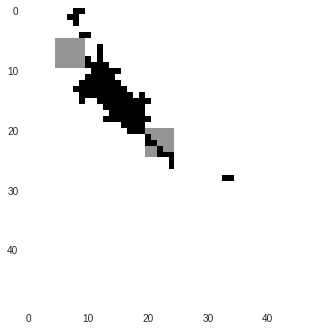

t=481


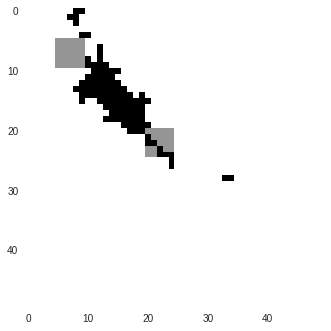

t=482


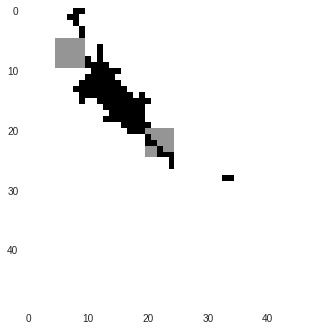

t=483


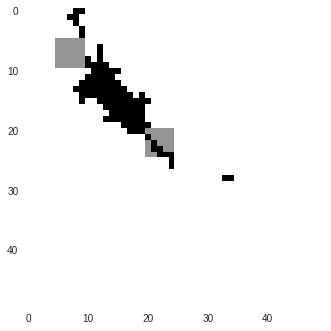

t=484


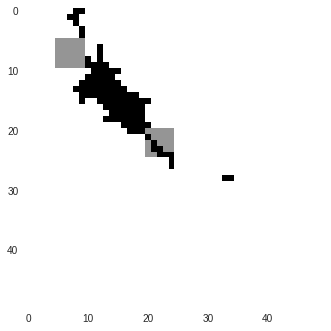

t=485


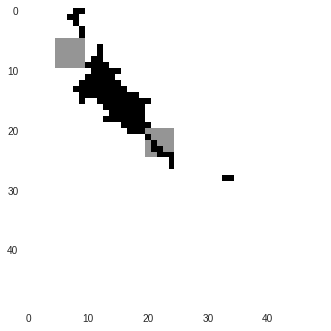

t=486


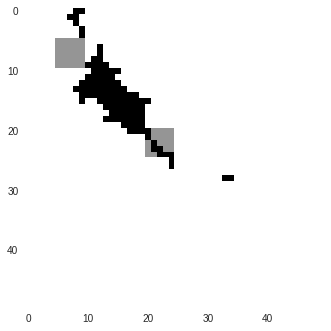

t=487


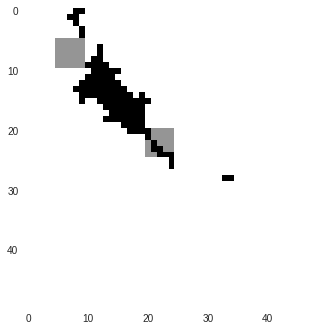

t=488


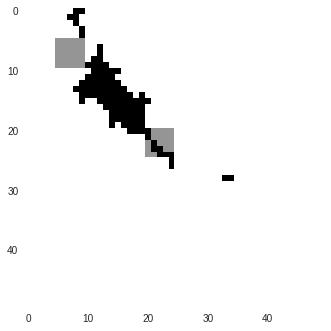

t=489


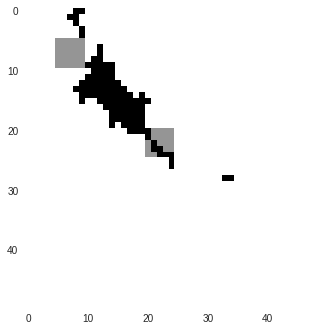

t=490


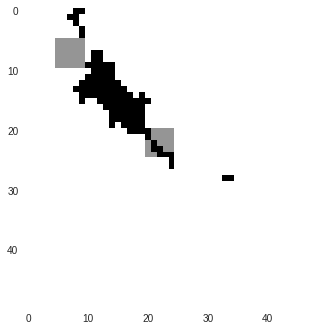

t=491


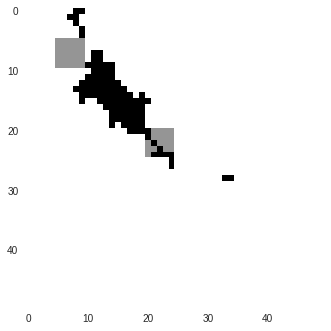

t=492


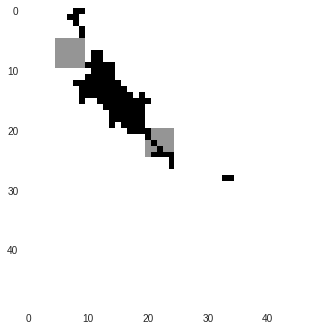

t=493


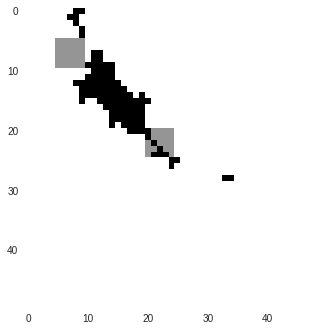

t=494


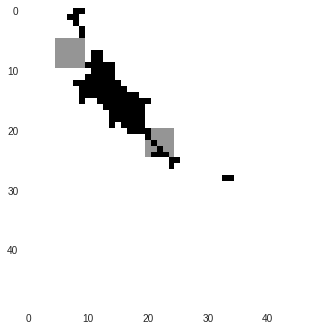

t=495


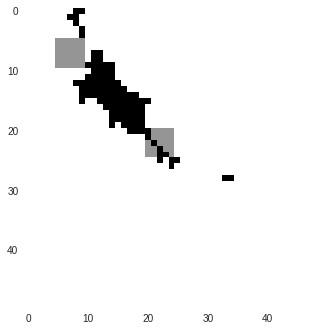

t=496


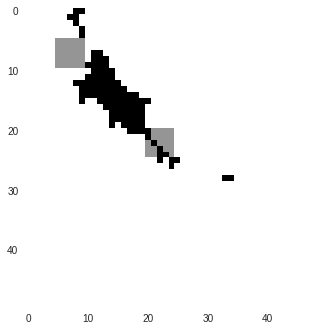

t=497


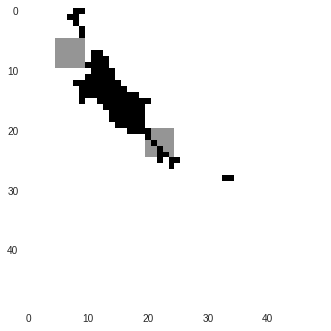

t=498


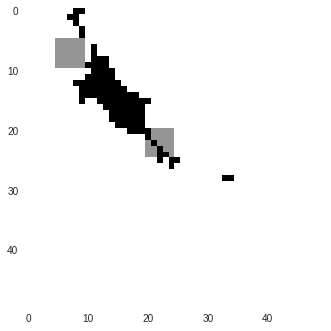

t=499


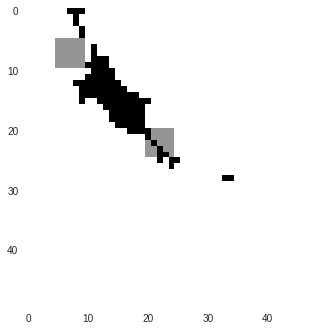

In [51]:
for t in range(500):
  timestep()
  if t%1==0:
    print 't='+str(t)
    plot_grid()

In [52]:
[]

[]